# Preprocess

In [9]:
import json
import numpy as np

# 定义输入文件名
input_file_path = 'trajectories-0400-0415.json'

# 初始化最大最小值
min_timestamp, max_timestamp = float('inf'), float('-inf')
min_position, max_position = float('inf'), float('-inf')

# 遍历文件以找到最大最小值
with open(input_file_path, 'r') as file:
    for line in file:
        record = json.loads(line)
        timestamps = np.array(record['timestamp']) / 1000  # 将时间戳从毫秒转换为秒
        local_y_positions = np.array(record['local_y']) * 0.3048  # 将位置从英尺转换为米

        # 更新最大最小值
        min_timestamp = min(min_timestamp, timestamps.min())
        max_timestamp = max(max_timestamp, timestamps.max())
        min_position = min(min_position, local_y_positions.min())
        max_position = max(max_position, local_y_positions.max())

# 打印出找到的最大最小值（可选）
print(f"Timestamp range: {min_timestamp} - {max_timestamp}")
print(f"Position range: {min_position} - {max_position}")

Timestamp range: 1113433135.3 - 1113434136.5
Position range: 0.0 - 535.6823424


# Create grids

In [10]:
def get_grid(min_x, max_x, min_t, max_t, x_res, t_res):
    x_grid = np.arange(min_x, max_x + x_res, x_res)
    t_grid = np.arange(min_t, max_t + t_res, t_res)
    return x_grid, t_grid

# 使用找到的最大最小值生成网格
min_timestamp, max_timestamp = 1113433135.3, 1113434136.5
min_position, max_position = 0.0, 535.6823424

x_res, t_res = 10, 2  # 分辨率可以根据需要调整
x_grid, t_grid = get_grid(min_position, max_position, min_timestamp, max_timestamp, x_res, t_res)

print(f"x_grid: {x_grid}")
print(f"t_grid: {t_grid}")

x_grid: [  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130.
 140. 150. 160. 170. 180. 190. 200. 210. 220. 230. 240. 250. 260. 270.
 280. 290. 300. 310. 320. 330. 340. 350. 360. 370. 380. 390. 400. 410.
 420. 430. 440. 450. 460. 470. 480. 490. 500. 510. 520. 530. 540.]
t_grid: [1.11343314e+09 1.11343314e+09 1.11343314e+09 1.11343314e+09
 1.11343314e+09 1.11343315e+09 1.11343315e+09 1.11343315e+09
 1.11343315e+09 1.11343315e+09 1.11343316e+09 1.11343316e+09
 1.11343316e+09 1.11343316e+09 1.11343316e+09 1.11343317e+09
 1.11343317e+09 1.11343317e+09 1.11343317e+09 1.11343317e+09
 1.11343318e+09 1.11343318e+09 1.11343318e+09 1.11343318e+09
 1.11343318e+09 1.11343319e+09 1.11343319e+09 1.11343319e+09
 1.11343319e+09 1.11343319e+09 1.11343320e+09 1.11343320e+09
 1.11343320e+09 1.11343320e+09 1.11343320e+09 1.11343321e+09
 1.11343321e+09 1.11343321e+09 1.11343321e+09 1.11343321e+09
 1.11343322e+09 1.11343322e+09 1.11343322e+09 1.11343322e+09
 1.11343322e+09 1.11343323e+09 1.

# Distribute the data into grids

In [11]:
def compute_speed(record):
    timestamps = np.array(record['timestamp']) / 1000  # 将时间戳从毫秒转换为秒
    local_y_positions = np.array(record['local_y']) * 0.3048  # 将位置从英尺转换为米
    
    sorted_indices = np.argsort(timestamps)
    timestamps = timestamps[sorted_indices]
    local_y_positions = local_y_positions[sorted_indices]

    timestamps += 9 * 3600  # 调整时间（向前移动9个小时）

    # 使用 np.unique 去重并保持顺序
    unique_timestamps, unique_indices = np.unique(timestamps, return_index=True)
    timestamps = unique_timestamps
    local_y_positions = local_y_positions[unique_indices]

    speed = np.diff(local_y_positions) / np.diff(timestamps)
    speed = np.append(speed[0], speed)  # 保持速度数组与位置数组长度一致
    speed *= 2.23694  # 将速度从 m/s 转换为 mph

    return timestamps, local_y_positions, speed

def grid_traj(record, x_grid, t_grid, x_t_speed_dict, x_t_density_dict):
    timestamps, positions, speed = compute_speed(record)
    
    for t, y, s in zip(timestamps, positions, speed):
        t_idx = np.searchsorted(t_grid, t) - 1
        x_idx = np.searchsorted(x_grid, y) - 1
        
        if t_idx >= 0 and t_idx < len(t_grid) - 1 and x_idx >= 0 and x_idx < len(x_grid) - 1:
            key = (x_grid[x_idx], t_grid[t_idx])
            if key not in x_t_speed_dict:
                x_t_speed_dict[key] = []
                x_t_density_dict[key] = 0
            x_t_speed_dict[key].append(s)
            x_t_density_dict[key] += 1

    # 调试信息
    print(f"Processed record: {record['vehicle_id']}")
    print(f"Timestamps: {timestamps[:10]}")
    print(f"Positions: {positions[:10]}")
    print(f"Speed: {speed[:10]}")
    print(f"x_t_speed_dict: {list(x_t_speed_dict.items())[:10]}")
    print(f"x_t_density_dict: {list(x_t_density_dict.items())[:10]}")

# 初始化全局速度和密度字典
global_x_t_speed_dict = {}
global_x_t_density_dict = {}

x_res, t_res = 10, 2  # 分辨率可以根据需要调整
x_grid, t_grid = get_grid(min_position, max_position, min_timestamp, max_timestamp, x_res, t_res)

# 重新遍历文件，处理每一条数据
with open(input_file_path, 'r') as file:
    i = 0
    for line in file:
        record = json.loads(line)
        grid_traj(record, x_grid, t_grid, global_x_t_speed_dict, global_x_t_density_dict)
        i += 1
        if i % 200 == 0:
            print(f"Processed {i} vehicles")
    print("Complete!")


Processed record: 1
Timestamps: [1.11346554e+09 1.11346554e+09 1.11346554e+09 1.11346554e+09
 1.11346554e+09 1.11346554e+09 1.11346554e+09 1.11346554e+09
 1.11346554e+09 1.11346554e+09]
Positions: [14.6953224 15.0763224 15.4570176 15.8383224 16.2193224 16.6003224
 16.9810176 17.3601888 17.7390552 18.1243224]
Speed: [8.52272921 8.52272921 8.51593133 8.52954739 8.52274953 8.52274953
 8.51591102 8.48184033 8.47500192 8.61820432]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 2
Timestamps: [1.11346557e+09 1.11346557e+09 1.11346557e+09 1.11346557e+09
 1.11346557e+09 1.11346557e+09 1.11346557e+09 1.11346557e+09
 1.11346557e+09 1.11346557e+09]
Positions: [20.1314304 20.7452976 21.2024976 21.8124024 22.2692976 22.728936
 23.1443784 23.5223304 23.85822   24.1657632]
Speed: [13.73185404 13.73185404 10.22727505 13.64321744 10.22048123 10.28182052
  9.29320609  8.45454737  7.51365598  6.87956342]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 4
Timestamps: [1.11346555e+09 1.1

Processed record: 44
Timestamps: [1.11346556e+09 1.11346556e+09 1.11346556e+09 1.11346556e+09
 1.11346556e+09 1.11346556e+09 1.11346556e+09 1.11346556e+09
 1.11346556e+09 1.11346556e+09]
Positions: [19.368516  20.130516  21.0504024 21.9644976 22.7264976 23.5482384
 24.3449856 25.1527056 25.9558536 26.7465048]
Speed: [17.04545842 17.04545842 20.57732646 20.44773192 17.04549906 18.38186618
 17.82273132 18.068229   17.96591317 17.68640982]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 45
Timestamps: [1.11346556e+09 1.11346556e+09 1.11346556e+09 1.11346556e+09
 1.11346556e+09 1.11346556e+09 1.11346556e+09 1.11346556e+09
 1.11346556e+09 1.11346556e+09]
Positions: [18.7186824 19.3282824 20.2426824 20.90166   21.5109552 22.2888048
 22.9572312 23.5689648 24.1197384 24.6119904]
Speed: [13.63636673 13.63636673 20.45459887 14.74091244 13.62958105 17.40004544
 14.95227612 13.68412664 12.32045734 11.01139239]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 46
Timestamps: [1.11

Processed record: 87
Timestamps: [1.11346557e+09 1.11346557e+09 1.11346557e+09 1.11346557e+09
 1.11346557e+09 1.11346557e+09 1.11346557e+09 1.11346557e+09
 1.11346557e+09 1.11346557e+09]
Positions: [20.898612  21.355812  21.660612  22.117812  22.575012  22.9304088
 23.3138472 23.725632  24.161496  24.586692 ]
Speed: [10.22727505 10.22727505  6.81819962 10.22729943 10.22727505  7.95002076
  8.57727468  9.21138769  9.75002546  9.5113658 ]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 89
Timestamps: [1.11346557e+09 1.11346557e+09 1.11346557e+09 1.11346557e+09
 1.11346557e+09 1.11346557e+09 1.11346557e+09 1.11346557e+09
 1.11346557e+09 1.11346557e+09]
Positions: [20.3953872 20.8026    21.2594952 21.717     22.1738952 22.6310952
 23.0879904 23.5458    24.009096  24.470868 ]
Speed: [ 9.1091147   9.1091147  10.22045687 10.23411763 10.22045687 10.22729943
 10.22048123 10.24091142 10.36366343 10.3295478 ]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 90
Timestamps: [1.11

Processed record: 141
Timestamps: [1.11346559e+09 1.11346559e+09 1.11346559e+09 1.11346559e+09
 1.11346559e+09 1.11346559e+09 1.11346559e+09 1.11346559e+09
 1.11346559e+09 1.11346559e+09]
Positions: [19.6507608 19.9555608 20.260056  20.442936  20.8998312 21.2040216
 21.5088216 21.7615008 22.0153992 22.2958152]
Speed: [ 6.81818337  6.81818337  6.81138142  4.09091977 10.22045687  6.80456322
  6.81818337  5.65228749  5.67956029  6.2727287 ]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 142
Timestamps: [1.1134656e+09 1.1134656e+09 1.1134656e+09 1.1134656e+09 1.1134656e+09
 1.1134656e+09 1.1134656e+09 1.1134656e+09 1.1134656e+09 1.1134656e+09]
Positions: [20.442936  20.8998312 21.6618312 21.9666312 22.4238312 22.7679504
 23.15718   23.5738416 24.01824   24.434292 ]
Speed: [10.22048123 10.22048123 17.04545842  6.81819962 10.22729943  7.69772902
  8.70684092  9.32045666  9.94093505  9.30684248]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 143
Timestamps: [1.11346561e+

Processed record: 169
Timestamps: [1.1134656e+09 1.1134656e+09 1.1134656e+09 1.1134656e+09 1.1134656e+09
 1.1134656e+09 1.1134656e+09 1.1134656e+09 1.1134656e+09 1.1134656e+09]
Positions: [20.2597512 20.5950312 20.7474312 20.900136  21.662136  22.0425264
 22.6152456 23.1428544 23.5738416 23.9179608]
Speed: [ 7.5000017   7.5000017   3.40909981  3.41590987 17.04549906  8.50911313
 12.81136655 11.80230355  9.64091128  7.69774737]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 173
Timestamps: [1.11346560e+09 1.11346560e+09 1.11346560e+09 1.11346561e+09
 1.11346561e+09 1.11346561e+09 1.11346561e+09 1.11346561e+09
 1.11346561e+09 1.11346561e+09]
Positions: [19.6425312 20.4045312 20.9007456 21.3576408 21.8151456 22.3485456
 22.8185472 23.2400856 23.6558328 24.1368072]
Speed: [17.04545842 17.04545842 11.10002899 10.22048123 10.23409323 11.93184934
 10.51363875  9.42957008  9.30002428 10.75909335]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 174
Timestamps: [1.1134656e+0

Processed record: 197
Timestamps: [1.11346561e+09 1.11346561e+09 1.11346561e+09 1.11346561e+09
 1.11346561e+09 1.11346561e+09 1.11346561e+09 1.11346561e+09
 1.11346561e+09 1.11346561e+09]
Positions: [19.3276728 19.9372728 20.2954128 21.1680552 21.99132   22.8273864
 23.6155992 24.3602256 25.0633992 25.7199384]
Speed: [13.63639924 13.63639924  8.01136546 19.52050552 18.41595718 18.70227697
 17.63186422 16.65682196 15.72958653 14.68640199]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 198
Timestamps: [1.11346560e+09 1.11346560e+09 1.11346560e+09 1.11346560e+09
 1.11346560e+09 1.11346560e+09 1.11346560e+09 1.11346560e+09
 1.11346560e+09 1.11346561e+09]
Positions: [38.8744968 39.331392  39.788592  40.3984968 40.855392  41.3421576
 41.8152072 42.2916096 42.7500288 43.206924 ]
Speed: [10.22048123 10.22048123 10.22727505 13.64321744 10.22048123 10.88863884
 10.58184581 10.6568206  10.25457223 10.22048123]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 200
Timestamps: [1

Processed record: 222
Timestamps: [1.11346561e+09 1.11346561e+09 1.11346561e+09 1.11346561e+09
 1.11346561e+09 1.11346561e+09 1.11346561e+09 1.11346561e+09
 1.11346561e+09 1.11346561e+09]
Positions: [20.7495648 21.6639648 22.57806   23.49246   24.10206   24.9439176
 25.7162808 26.49474   27.2661888 28.0501344]
Speed: [20.45459887 20.45459887 20.44773192 20.45459887 13.63639924 18.83182246
 17.27731784 17.41364032 17.25686324 17.53640943]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 224
Timestamps: [1.11346561e+09 1.11346561e+09 1.11346561e+09 1.11346561e+09
 1.11346561e+09 1.11346561e+09 1.11346561e+09 1.11346561e+09
 1.11346561e+09 1.11346561e+09]
Positions: [11.4769392 11.989308  12.5019816 13.0146552 13.527024  14.05128
 14.5691352 15.0827232 15.5953968 16.1089848]
Speed: [11.46139357 11.46139357 11.46821176 11.46818442 11.46139357 11.72727539
 11.58412116 11.48866636 11.46818442 11.48866636]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 230
Timestamps: [1.1

Processed record: 277
Timestamps: [1.11346563e+09 1.11346563e+09 1.11346563e+09 1.11346563e+09
 1.11346563e+09 1.11346563e+09 1.11346563e+09 1.11346563e+09
 1.11346563e+09 1.11346563e+09]
Positions: [19.6653912 19.970496  20.4990192 21.0324192 21.5658192 22.0992192
 22.632924  23.1672384 23.6982    24.2236752]
Speed: [ 6.82501782  6.82501782 11.82272996 11.93184934 11.93182089 11.93184934
 11.93866754 11.95227544 11.87730374 11.75454812]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 278
Timestamps: [1.11346565e+09 1.11346565e+09 1.11346565e+09 1.11346565e+09
 1.11346565e+09 1.11346565e+09 1.11346565e+09 1.11346565e+09
 1.11346565e+09 1.11346565e+09]
Positions: [19.21764   20.7452976 22.1168976 23.6408976 24.7080024 26.0875272
 27.3820128 28.6667448 29.899356  31.1280048]
Speed: [34.17281651 34.17281651 30.6818983  34.09091683 23.87051688 30.85909792
 28.9568938  28.73871141 27.57273353 27.48416268]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 279
Timestamps: [1

Processed record: 311
Timestamps: [1.11346564e+09 1.11346564e+09 1.11346564e+09 1.11346564e+09
 1.11346564e+09 1.11346564e+09 1.11346564e+09 1.11346564e+09
 1.11346564e+09 1.11346564e+09]
Positions: [20.1155808 20.7471264 21.3567264 21.9660216 22.4235264 22.9733856
 23.4805728 23.9926368 24.5202456 25.091136 ]
Speed: [14.12730962 14.12730962 13.63636673 13.62958105 10.23409323 12.30003212
 11.34548417 11.45454806 11.80230355 12.77045745]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 312
Timestamps: [1.11346567e+09 1.11346567e+09 1.11346567e+09 1.11346567e+09
 1.11346567e+09 1.11346567e+09 1.11346567e+09 1.11346567e+09
 1.11346567e+09 1.11346567e+09]
Positions: [19.1219328 21.870924  24.614124  27.250644  29.887164  32.5230744
 35.1583752 37.7948952 40.4289768 43.0581816]
Speed: [61.49334239 61.49334239 61.3636503  58.97742673 58.97728612 58.96379033
 58.95015393 58.97728612 58.92288114 58.81364972]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 314
Timestamps: [1

Processed record: 344
Timestamps: [1.11346565e+09 1.11346565e+09 1.11346565e+09 1.11346565e+09
 1.11346565e+09 1.11346565e+09 1.11346566e+09 1.11346566e+09
 1.11346566e+09 1.11346566e+09]
Positions: [30.5574192 31.2432192 31.9290192 32.6148192 33.2920848 33.9769704
 34.6642944 35.3580192 36.0450384 36.6924336]
Speed: [15.34094915 15.34094915 15.34094915 15.34091257 15.15003956 15.32045802
 15.37504015 15.51822234 15.36818531 14.481856  ]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 346
Timestamps: [1.11346566e+09 1.11346566e+09 1.11346566e+09 1.11346566e+09
 1.11346566e+09 1.11346566e+09 1.11346566e+09 1.11346566e+09
 1.11346566e+09 1.11346566e+09]
Positions: [19.3438272 24.252936  24.9180096 25.7409696 26.5639296 27.3868896
 28.2098496 29.0328096 29.8557696 30.6793392]
Speed: [109.81392312 109.81392312  14.87731158  18.40909509  18.40913898
  18.40909509  18.40913898  18.40913898  18.40909509  18.42277538]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 347
Time

Processed record: 388
Timestamps: [1.11346567e+09 1.11346567e+09 1.11346567e+09 1.11346567e+09
 1.11346567e+09 1.11346567e+09 1.11346567e+09 1.11346567e+09
 1.11346567e+09 1.11346567e+09]
Positions: [113.597436  114.511836  115.273836  116.035836  116.7975312 117.7326576
 118.6299888 119.4931824 120.3179712 121.1345304]
Speed: [20.45459887 20.45459887 17.04545842 17.04549906 17.03864023 20.91823644
 20.07277969 19.30909529 18.45004818 18.26591324]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 389
Timestamps: [1.11346568e+09 1.11346568e+09 1.11346568e+09 1.11346568e+09
 1.11346568e+09 1.11346568e+09 1.11346568e+09 1.11346568e+09
 1.11346568e+09 1.11346568e+09]
Positions: [20.0911968 21.05406   21.96846   22.73046   23.79726   24.5778528
 25.5032256 26.4663936 27.47772   28.43784  ]
Speed: [21.53869261 21.53869261 20.4545501  17.04549906 23.86364178 17.46140923
 20.70005405 21.54545944 22.62278635 21.4772776 ]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 390
Time

Processed record: 409
Timestamps: [1.11346566e+09 1.11346566e+09 1.11346566e+09 1.11346566e+09
 1.11346566e+09 1.11346566e+09 1.11346566e+09 1.11346566e+09
 1.11346566e+09 1.11346566e+09]
Positions: [19.6327776 20.59686   21.35886   22.27326   23.03526   23.916132
 24.7348248 25.5196848 26.2670544 27.0080232]
Speed: [21.56596541 21.56596541 17.04545842 20.45459887 17.04545842 19.70459691
 18.31368419 17.55682217 16.71822547 16.57500376]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 411
Timestamps: [1.11346567e+09 1.11346567e+09 1.11346567e+09 1.11346567e+09
 1.11346567e+09 1.11346567e+09 1.11346567e+09 1.11346567e+09
 1.11346567e+09 1.11346567e+09]
Positions: [101.2935744 102.2079744 102.8175744 103.3817592 104.1443688 104.7981648
 105.5211504 106.279188  107.0862984 107.9010288]
Speed: [20.45459887 20.45459887 13.63639924 12.62045741 17.05913546 14.62500332
 16.1727695  16.95686246 18.05454955 18.22504759]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 412
Times

Processed record: 445
Timestamps: [1.11346568e+09 1.11346568e+09 1.11346568e+09 1.11346568e+09
 1.11346568e+09 1.11346568e+09 1.11346568e+09 1.11346568e+09
 1.11346568e+09 1.11346568e+09]
Positions: [20.2512168 21.0534504 21.9675456 22.7295456 23.4915456 24.3577872
 25.17648   25.9485384 26.6742672 27.3881088]
Speed: [17.94550141 17.94550141 20.44773192 17.04549906 17.04545842 19.37732333
 18.31368419 17.27045847 16.2341333  15.96818544]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 447
Timestamps: [1.11346569e+09 1.11346569e+09 1.11346569e+09 1.11346569e+09
 1.11346569e+09 1.11346569e+09 1.11346569e+09 1.11346569e+09
 1.11346569e+09 1.11346569e+09]
Positions: [11.1322104 12.2907552 13.4486904 14.6447256 15.8029656 16.9618152
 18.1194456 19.2871344 20.4572616 21.6258648]
Speed: [25.91597676 25.91597676 25.90227861 26.75461532 25.90909679 25.92279496
 25.89552217 26.12046048 26.17506835 26.14091503]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 448
Timestamps: [1

Processed record: 495
Timestamps: [1.11346571e+09 1.11346571e+09 1.11346571e+09 1.11346571e+09
 1.11346571e+09 1.11346571e+09 1.11346571e+09 1.11346571e+09
 1.11346571e+09 1.11346571e+09]
Positions: [ 99.7692696 101.1408696 102.5127744 103.6871688 105.0587688 106.5211992
 107.9878968 109.479588  110.9895672 112.5239304]
Speed: [30.6818983  30.6818983  30.68864333 26.27052314 30.68182515 32.71372179
 32.80917658 33.3681894  33.77736093 34.32273507]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 496
Timestamps: [1.11346572e+09 1.11346572e+09 1.11346572e+09 1.11346572e+09
 1.11346572e+09 1.11346572e+09 1.11346572e+09 1.11346572e+09
 1.11346572e+09 1.11346572e+09]
Positions: [ 6.3178944  8.7861648 11.2550448 13.7239248 16.1976816 18.6677808
 21.1384896 23.6088936 26.078688  28.5466536]
Speed: [55.2136489  55.2136489  55.22741694 55.22728527 55.33650813 55.25468974
 55.26819437 55.26150794 55.24773982 55.20696234]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 498
Time

Processed record: 519
Timestamps: [1.11346571e+09 1.11346571e+09 1.11346571e+09 1.11346571e+09
 1.11346571e+09 1.11346571e+09 1.11346571e+09 1.11346571e+09
 1.11346571e+09 1.11346571e+09]
Positions: [19.8586344 20.7727296 21.6566496 22.5405696 23.4244896 24.2730528
 25.0859544 25.8689856 26.63952   27.4115784]
Speed: [20.44778067 20.44778067 19.77273176 19.7727789  19.77273176 18.98186775
 18.18413839 17.51591307 17.23640865 17.27045847]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 520
Timestamps: [1.11346572e+09 1.11346572e+09 1.11346572e+09 1.11346572e+09
 1.11346572e+09 1.11346572e+09 1.11346572e+09 1.11346572e+09
 1.11346572e+09 1.11346572e+09]
Positions: [101.598984  102.970584  104.2989024 105.6708072 107.0424072 108.382308
 109.7292192 111.0773496 112.4068872 113.6900952]
Speed: [30.6818983  30.6818983  29.71371395 30.68864333 30.6818983  29.97273408
 30.12962413 30.15689693 29.74091584 28.70462041]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 521
Times

Processed record: 559
Timestamps: [1.11346572e+09 1.11346572e+09 1.11346572e+09 1.11346572e+09
 1.11346572e+09 1.11346572e+09 1.11346572e+09 1.11346572e+09
 1.11346572e+09 1.11346572e+09]
Positions: [ 7.7781912  8.6925912  9.6069912 10.5213912 11.436096  12.3501912
 13.2764784 14.2076424 15.1357584 16.0498536]
Speed: [20.45459887 20.45459887 20.4545501  20.45459887 20.46136828 20.44778067
 20.72050865 20.82955018 20.76141785 20.44773192]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 561
Timestamps: [1.11346570e+09 1.11346571e+09 1.11346571e+09 1.11346571e+09
 1.11346571e+09 1.11346571e+09 1.11346571e+09 1.11346571e+09
 1.11346571e+09 1.11346571e+09]
Positions: [19.6650864 20.4411072 21.2031072 21.965412  22.727412  23.4839256
 24.1825272 24.8296176 25.39746   25.8671568]
Speed: [17.35913624 17.35913624 17.04545842 17.05231726 17.04545842 16.92277146
 15.62731353 14.47500329 12.7023059  10.50682057]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 562
Timestamps: [1

Processed record: 636
Timestamps: [1.11346573e+09 1.11346573e+09 1.11346573e+09 1.11346573e+09
 1.11346573e+09 1.11346573e+09 1.11346573e+09 1.11346573e+09
 1.11346573e+09 1.11346573e+09]
Positions: [20.898612  21.660612  22.270212  23.184612  23.946612  24.6488712
 25.3203456 25.985724  26.6767056 27.4085304]
Speed: [17.04545842 17.04545842 13.63639924 20.4545501  17.04549906 15.70913193
 15.02045796 14.88412978 15.45682169 16.37049729]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 638
Timestamps: [1.11346574e+09 1.11346574e+09 1.11346574e+09 1.11346574e+09
 1.11346574e+09 1.11346574e+09 1.11346574e+09 1.11346574e+09
 1.11346574e+09 1.11346574e+09]
Positions: [102.056184  103.5356832 104.9078928 106.431588  107.803188  109.1982576
 110.5460832 111.8643432 113.1484656 114.4085088]
Speed: [33.09546206 33.09546206 30.6955347  34.08409865 30.6818983  31.20689967
 30.15000685 29.48871337 28.72500652 28.18643724]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 640
Time

Processed record: 705
Timestamps: [1.11346574e+09 1.11346574e+09 1.11346574e+09 1.11346574e+09
 1.11346574e+09 1.11346574e+09 1.11346574e+09 1.11346574e+09
 1.11346574e+09 1.11346574e+09]
Positions: [101.4468888 102.8184888 103.9937976 105.3653976 106.5849024 107.8095888
 109.0342752 110.2915752 111.5653344 112.8317784]
Speed: [30.68182515 30.68182515 26.29097774 30.68182515 27.27961669 27.39552608
 27.39546077 28.12507344 28.49318829 28.32961943]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 706
Timestamps: [1.11346574e+09 1.11346575e+09 1.11346575e+09 1.11346575e+09
 1.11346575e+09 1.11346575e+09 1.11346575e+09 1.11346575e+09
 1.11346575e+09 1.11346575e+09]
Positions: [20.2670664 21.136356  21.9827856 22.82952   23.6762544 24.5229888
 25.3694184 26.2161528 27.0625824 27.9093168]
Speed: [19.44550532 19.44550532 18.93409521 18.94095855 18.94091339 18.94095855
 18.93414035 18.94091339 18.93414035 18.94091339]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 707
Time

Processed record: 733
Timestamps: [1.11346575e+09 1.11346575e+09 1.11346575e+09 1.11346575e+09
 1.11346575e+09 1.11346575e+09 1.11346575e+09 1.11346575e+09
 1.11346575e+09 1.11346575e+09]
Positions: [20.2518264 21.2055456 21.9675456 22.8819456 23.6439456 24.580596
 25.5199896 26.4895584 27.4237704 28.31592  ]
Speed: [21.33414662 21.33414662 17.04545842 20.45459887 17.04545842 20.95232744
 21.01369124 21.68864129 20.89778184 19.95682271]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 737
Timestamps: [1.11346575e+09 1.11346575e+09 1.11346575e+09 1.11346575e+09
 1.11346575e+09 1.11346575e+09 1.11346575e+09 1.11346575e+09
 1.11346575e+09 1.11346575e+09]
Positions: [19.1743584 20.0887584 21.2067648 21.9687648 23.03526   23.4750864
 24.0249456 24.4745256 24.8186448 25.2855984]
Speed: [20.4545501  20.4545501  25.00915621 17.04545842 23.85688048  9.83866206
 12.30000279 10.05684444  7.69772902 10.44548182]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 738
Timestamps: [1.

Processed record: 765
Timestamps: [1.11346575e+09 1.11346575e+09 1.11346575e+09 1.11346575e+09
 1.11346575e+09 1.11346575e+09 1.11346575e+09 1.11346575e+09
 1.11346575e+09 1.11346575e+09]
Positions: [19.5050664 20.1149712 20.8992216 21.5091264 22.2711264 22.9779576
 23.681436  24.362664  25.0566936 25.784556 ]
Speed: [13.64318492 13.64318492 17.54322763 13.64318492 17.04549906 15.81140492
 15.73636721 15.23867616 15.52500353 16.2818607 ]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 766
Timestamps: [1.11346576e+09 1.11346576e+09 1.11346576e+09 1.11346576e+09
 1.11346576e+09 1.11346576e+09 1.11346576e+09 1.11346576e+09
 1.11346576e+09 1.11346576e+09]
Positions: [19.665696  20.122896  20.746212  21.0513168 21.660612  22.108668
 22.5850704 23.0340408 23.490936  23.9514888]
Speed: [10.22729943 10.22729943 13.94318498  6.82501782 13.62958105 10.02272955
 10.65684601 10.0431841  10.22048123 10.30229963]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 767
Timestamps: [1.

Processed record: 797
Timestamps: [1.11346577e+09 1.11346577e+09 1.11346577e+09 1.11346577e+09
 1.11346577e+09 1.11346577e+09 1.11346577e+09 1.11346577e+09
 1.11346577e+09 1.11346577e+09]
Positions: [19.0289688 20.7486504 21.9678504 23.3394504 24.7113552 26.165556
 27.5847048 28.991052  30.4141632 31.88208  ]
Speed: [38.46819055 38.46819055 27.27279849 30.6818983  30.68864333 32.5296304
 31.74546175 31.45917306 31.83417404 32.83637109]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 798
Timestamps: [1.11346575e+09 1.11346575e+09 1.11346575e+09 1.11346575e+09
 1.11346575e+09 1.11346576e+09 1.11346576e+09 1.11346576e+09
 1.11346576e+09 1.11346576e+09]
Positions: [19.481292  20.3953872 21.20646   22.12086   23.03526   23.7679992
 24.5187216 25.2151896 25.8784344 26.5428984]
Speed: [20.44778067 20.44778067 18.14318594 20.45459887 20.4545501  16.39095189
 16.79322567 15.57954899 14.83640238 14.86363974]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 804
Timestamps: [1.1

Processed record: 875
Timestamps: [1.11346579e+09 1.11346579e+09 1.11346579e+09 1.11346579e+09
 1.11346579e+09 1.11346579e+09 1.11346579e+09 1.11346579e+09
 1.11346579e+09 1.11346579e+09]
Positions: [19.6510656 20.5950312 21.3570312 22.2714312 23.0334312 23.9417352
 24.8027952 25.6422144 26.4395712 27.207972 ]
Speed: [21.11591389 21.11591389 17.04549906 20.4545501  17.04549906 20.31823487
 19.26136801 18.77732176 17.83636769 17.18868125]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 876
Timestamps: [1.11346578e+09 1.11346578e+09 1.11346578e+09 1.11346578e+09
 1.11346578e+09 1.11346578e+09 1.11346578e+09 1.11346578e+09
 1.11346578e+09 1.11346578e+09]
Positions: [19.0487808 20.1155808 21.3567264 22.4232216 23.6427264 24.8948448
 26.12898   27.3119088 28.4570424 29.5954704]
Speed: [23.86369868 23.86369868 27.76364267 23.85688048 27.27955165 28.00916405
 27.60689027 26.46136965 25.61597598 25.46591487]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 877
Timestamps: [1

Processed record: 904
Timestamps: [1.1134658e+09 1.1134658e+09 1.1134658e+09 1.1134658e+09 1.1134658e+09
 1.1134658e+09 1.1134658e+09 1.1134658e+09 1.1134658e+09 1.1134658e+09]
Positions: [ 7.453884   8.429244   9.404604  10.379964  11.3550192 12.3303792
 13.3200648 14.3097504 15.2945592 16.2821112]
Speed: [21.81823879 21.81823879 21.81818677 21.81823879 21.81136859 21.81823879
 22.13869417 22.13864139 22.02960298 22.09091411]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 905
Timestamps: [1.11346579e+09 1.11346579e+09 1.11346579e+09 1.11346579e+09
 1.11346579e+09 1.11346579e+09 1.11346579e+09 1.11346579e+09
 1.11346579e+09 1.11346579e+09]
Positions: [19.054572  20.3313792 21.4408512 22.5356928 23.6302296 24.7247664
 25.8193032 26.91384   28.0086816 29.096208 ]
Speed: [28.56137012 28.56137012 24.81824663 24.49091465 24.48415484 24.48415484
 24.48409647 24.48415484 24.49091465 24.32733625]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 906
Timestamps: [1.1134658e+0

Processed record: 978
Timestamps: [1.11346581e+09 1.11346581e+09 1.11346581e+09 1.11346581e+09
 1.11346581e+09 1.11346581e+09 1.11346581e+09 1.11346581e+09
 1.11346581e+09 1.11346581e+09]
Positions: [20.7474312 21.8142312 22.8810312 23.9478312 25.1670312 26.4471912
 27.64536   28.8011616 29.8923456 30.9774336]
Speed: [23.86369868 23.86369868 23.86369868 23.86364178 27.27279849 28.63637014
 26.80234272 25.85461297 24.40909645 24.27279066]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 981
Timestamps: [1.11346582e+09 1.11346582e+09 1.11346582e+09 1.11346582e+09
 1.11346582e+09 1.11346582e+09 1.11346582e+09 1.11346582e+09
 1.11346582e+09 1.11346582e+09]
Positions: [20.7483456 21.9675456 23.1867456 24.3081048 25.4002032 26.4941304
 27.5779992 28.66644   29.7795696 30.9372   ]
Speed: [27.27273347 27.27273347 27.27279849 25.08409661 24.42960925 24.47051844
 24.24546005 24.34779085 24.90000565 25.89552217]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 982
Timestamps: [1

Processed record: 1013
Timestamps: [1.11346581e+09 1.11346581e+09 1.11346581e+09 1.11346581e+09
 1.11346581e+09 1.11346581e+09 1.11346581e+09 1.11346581e+09
 1.11346581e+09 1.11346581e+09]
Positions: [20.1222864 21.203412  22.270212  23.337012  24.403812  25.4209296
 26.39568   27.3225768 28.2202128 29.122116 ]
Speed: [24.18415406 24.18415406 23.86369868 23.86364178 23.86369868 22.75227789
 21.80460239 20.73414505 20.07955001 20.17505268]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1014
Timestamps: [1.11346582e+09 1.11346582e+09 1.11346582e+09 1.11346582e+09
 1.11346582e+09 1.11346582e+09 1.11346582e+09 1.11346582e+09
 1.11346582e+09 1.11346582e+09]
Positions: [19.5059808 20.4423264 21.3564216 22.2708216 23.4900216 24.4760496
 25.4956056 26.4935208 27.5085048 28.5244032]
Speed: [20.94550924 20.94550924 20.44778067 20.4545501  27.27279849 22.05682319
 22.80687774 22.32278556 22.70455061 22.72505934]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1015
Timestamps:

Processed record: 1045
Timestamps: [1.11346582e+09 1.11346582e+09 1.11346582e+09 1.11346582e+09
 1.11346582e+09 1.11346582e+09 1.11346582e+09 1.11346582e+09
 1.11346582e+09 1.11346582e+09]
Positions: [19.9711056 21.051012  22.1175072 23.184612  24.251412  25.749504
 27.0074136 28.1994864 29.3147496 30.3455832]
Speed: [24.15682367 24.15682367 23.85688048 23.87051688 23.86364178 33.51145114
 28.13864275 26.66597872 24.94779242 23.05909615]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1048
Timestamps: [1.11346583e+09 1.11346583e+09 1.11346583e+09 1.11346583e+09
 1.11346583e+09 1.11346583e+09 1.11346583e+09 1.11346583e+09
 1.11346583e+09 1.11346583e+09]
Positions: [17.8573176 18.9238128 19.9906128 21.1074    22.1742    23.2437432
 24.3074952 25.3742952 26.4407904 27.5078952]
Speed: [23.8568236  23.8568236  23.86369868 24.98182385 23.86369868 23.92506247
 23.79545995 23.86369868 23.8568236  23.87051688]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1049
Timestamps: 

Processed record: 1080
Timestamps: [1.11346583e+09 1.11346583e+09 1.11346583e+09 1.11346583e+09
 1.11346583e+09 1.11346583e+09 1.11346583e+09 1.11346583e+09
 1.11346583e+09 1.11346583e+09]
Positions: [19.6669152 20.7459072 21.6603072 22.879812  23.9463072 24.87168
 25.7949192 26.7291312 27.7023576 28.7127696]
Speed: [24.13642666 24.13642666 20.4545501  27.27961669 23.85688048 20.7000047
 20.65232666 20.89773202 21.77051139 22.60233175]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1083
Timestamps: [1.11346584e+09 1.11346584e+09 1.11346584e+09 1.11346584e+09
 1.11346584e+09 1.11346584e+09 1.11346584e+09 1.11346584e+09
 1.11346584e+09 1.11346584e+09]
Positions: [19.6571616 20.5944216 21.4131144 22.4341944 23.4552744 24.4763544
 25.4974344 26.5188192 27.5395944 28.5579312]
Speed: [20.96596384 20.96596384 18.31364052 22.84096873 22.84096873 22.84091428
 22.84096873 22.84773246 22.83415054 22.77960494]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1084
Timestamps: [1

Processed record: 1106
Timestamps: [1.11346584e+09 1.11346584e+09 1.11346584e+09 1.11346584e+09
 1.11346584e+09 1.11346584e+09 1.11346584e+09 1.11346584e+09
 1.11346584e+09 1.11346585e+09]
Positions: [21.20646   22.42566   23.49246   24.7113552 25.62606   26.6504928
 27.674316  28.7511744 29.8725336 31.0329072]
Speed: [27.27279849 27.27279849 23.86364178 27.26598029 20.46141707 22.91591429
 22.90233253 24.08864183 25.08415641 25.95688596]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1110
Timestamps: [1.11346583e+09 1.11346583e+09 1.11346583e+09 1.11346583e+09
 1.11346583e+09 1.11346583e+09 1.11346583e+09 1.11346583e+09
 1.11346583e+09 1.11346583e+09]
Positions: [21.2031072 22.1175072 23.0898192 24.0499392 25.0100592 25.970484
 26.930604  27.8898096 28.8535872 29.8234608]
Speed: [20.45459887 20.45459887 21.75000494 21.47732881 21.47732881 21.48409579
 21.47732881 21.45682305 21.55914721 21.6955112 ]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1111
Timestamps: 

Processed record: 1134
Timestamps: [1.11346586e+09 1.11346586e+09 1.11346586e+09 1.11346586e+09
 1.11346586e+09 1.11346586e+09 1.11346586e+09 1.11346586e+09
 1.11346586e+09 1.11346586e+09]
Positions: [19.8019416 20.7474312 21.814536  22.728936  23.643336  24.5107968
 25.4114808 26.3414256 27.2908776 28.2400248]
Speed: [21.1500048  21.1500048  23.87051688 20.45459887 20.4545501  19.40459613
 20.14773185 20.80232705 21.23869182 21.231823  ]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1135
Timestamps: [1.11346586e+09 1.11346586e+09 1.11346586e+09 1.11346586e+09
 1.11346586e+09 1.11346586e+09 1.11346586e+09 1.11346586e+09
 1.11346586e+09 1.11346586e+09]
Positions: [12.83208   14.1271752 15.3975816 16.6673784 17.5665384 18.495264
 19.371564  20.2719432 21.17598   22.0848936]
Speed: [28.97046112 28.97046112 28.41825603 28.40461963 20.11364093 20.77505425
 19.60227718 20.14096168 20.22278008 20.3318228 ]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1136
Timestamps: 

Processed record: 1164
Timestamps: [1.11346588e+09 1.11346588e+09 1.11346588e+09 1.11346588e+09
 1.11346588e+09 1.11346588e+09 1.11346588e+09 1.11346588e+09
 1.11346588e+09 1.11346588e+09]
Positions: [26.9940024 28.8228024 30.6516024 32.4804024 34.3076784 35.998404
 37.7260104 39.5151864 41.349168  43.2200304]
Speed: [40.9091002  40.9091002  40.90919773 40.9091002  40.87510674 37.82055331
 38.64546332 40.02283178 41.02500932 41.85010928]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1165
Timestamps: [1.11346586e+09 1.11346586e+09 1.11346586e+09 1.11346586e+09
 1.11346586e+09 1.11346586e+09 1.11346586e+09 1.11346586e+09
 1.11346586e+09 1.11346586e+09]
Positions: [20.121372  20.746212  21.2037168 21.9657168 22.7277168 23.4470448
 24.1185192 24.737568  25.2977904 25.8071112]
Speed: [13.97730923 13.97730923 10.23411763 17.04545842 17.04549906 16.09091274
 15.02049377 13.84776343 12.53182103 11.39321157]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1167
Timestamps: 

Processed record: 1191
Timestamps: [1.11346587e+09 1.11346587e+09 1.11346587e+09 1.11346587e+09
 1.11346587e+09 1.11346587e+09 1.11346587e+09 1.11346587e+09
 1.11346587e+09 1.11346587e+09]
Positions: [18.423636  19.642836  20.7483456 21.6627456 22.5771456 23.5342176
 24.4672104 25.3724664 26.2426704 27.0842232]
Speed: [27.27279849 27.27279849 24.72955107 20.45459887 20.4545501  21.40914681
 20.87050904 20.2500046  19.46595992 18.82500427]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1192
Timestamps: [1.11346587e+09 1.11346587e+09 1.11346587e+09 1.11346587e+09
 1.11346587e+09 1.11346587e+09 1.11346587e+09 1.11346587e+09
 1.11346587e+09 1.11346587e+09]
Positions: [19.7949312 20.7483456 21.6627456 22.5771456 23.4915456 24.423624
 25.3633224 26.2914384 27.1863312 28.0626312]
Speed: [21.32727757 21.32727757 20.45459887 20.45459887 20.4545501  20.85005445
 21.02045932 20.76141785 20.01823409 19.60227718]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1193
Timestamps: 

Processed record: 1218
Timestamps: [1.11346588e+09 1.11346588e+09 1.11346588e+09 1.11346588e+09
 1.11346588e+09 1.11346588e+09 1.11346588e+09 1.11346588e+09
 1.11346588e+09 1.11346588e+09]
Positions: [19.1914272 20.106132  21.357336  22.4793048 23.490936  24.5114064
 25.5157224 26.5255248 27.5362416 28.5478728]
Speed: [20.46136828 20.46136828 27.98870945 25.09773297 22.62960455 22.82733234
 22.46591419 22.58869535 22.60909604 22.62960455]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1219
Timestamps: [1.11346589e+09 1.11346589e+09 1.11346589e+09 1.11346589e+09
 1.11346589e+09 1.11346589e+09 1.11346589e+09 1.11346589e+09
 1.11346589e+09 1.11346589e+09]
Positions: [18.8713872 19.9381872 21.0537552 21.96846   23.18766   24.28494
 25.3755144 26.4075672 27.4307808 28.4814264]
Speed: [23.86369868 23.86369868 24.95461062 20.46136828 27.27279849 24.54546012
 24.39551825 23.08642392 22.88864156 23.5023341 ]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1220
Timestamps: [

Processed record: 1238
Timestamps: [1.11346589e+09 1.11346589e+09 1.11346589e+09 1.11346589e+09
 1.11346589e+09 1.11346589e+09 1.11346589e+09 1.11346589e+09
 1.11346589e+09 1.11346589e+09]
Positions: [19.8095616 20.7468216 21.5088216 22.4232216 23.8515144 24.9954288
 26.1859776 27.3301968 28.4863032 29.6408856]
Speed: [20.96591385 20.96591385 17.04549906 20.4545501  31.95008343 25.58870318
 26.63182423 25.59552138 25.86136951 25.82734017]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1239
Timestamps: [1.11346588e+09 1.11346588e+09 1.11346588e+09 1.11346588e+09
 1.11346589e+09 1.11346589e+09 1.11346589e+09 1.11346589e+09
 1.11346589e+09 1.11346589e+09]
Positions: [19.6510656 20.7474312 21.5094312 22.7286312 23.7954312 24.748236
 25.6912872 26.577036  27.4188936 28.2095448]
Speed: [24.52506404 24.52506404 17.04545842 27.27279849 23.86369868 21.3136412
 21.09550963 19.81364086 18.83186736 17.68640982]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1240
Timestamps: [

Processed record: 1258
Timestamps: [1.11346589e+09 1.11346589e+09 1.11346589e+09 1.11346589e+09
 1.11346589e+09 1.11346589e+09 1.11346589e+09 1.11346589e+09
 1.11346589e+09 1.11346589e+09]
Positions: [18.8881512 19.6501512 20.595336  21.814536  22.728936  23.8938816
 24.9936    26.0899656 27.1582896 28.222956 ]
Speed: [17.04549906 17.04549906 21.14318662 27.27279849 20.45459887 26.05909683
 24.60006424 24.52500557 23.89778968 23.81597128]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1259
Timestamps: [1.1134659e+09 1.1134659e+09 1.1134659e+09 1.1134659e+09 1.1134659e+09
 1.1134659e+09 1.1134659e+09 1.1134659e+09 1.1134659e+09 1.1134659e+09]
Positions: [20.7489552 21.8157552 23.3397552 24.40686   25.7781552 26.9815056
 28.2342336 29.4829992 30.7518816 32.020764 ]
Speed: [23.86369868 23.86369868 34.09099811 23.87045997 30.6750801  26.91818793
 28.02280045 27.93416385 28.38409735 28.38416503]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1260
Timestamps: [1.1134659

Processed record: 1300
Timestamps: [1.11346592e+09 1.11346592e+09 1.11346592e+09 1.11346592e+09
 1.11346592e+09 1.11346592e+09 1.11346592e+09 1.11346592e+09
 1.11346592e+09 1.11346592e+09]
Positions: [19.0326264 20.4042264 21.8151456 22.8819456 24.1011456 25.3072392
 26.5605768 27.8514048 29.1827712 30.5464464]
Speed: [30.68182515 30.68182515 31.56144605 23.86364178 27.27279849 26.97961591
 28.03637    28.8750754  29.78182494 30.50462511]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1301
Timestamps: [1.11346592e+09 1.11346592e+09 1.11346592e+09 1.11346592e+09
 1.11346592e+09 1.11346592e+09 1.11346592e+09 1.11346592e+09
 1.11346592e+09 1.11346592e+09]
Positions: [19.0307976 20.0975976 21.2058504 22.2726504 23.1867456 23.9639856
 24.6772176 25.312116  25.8464304 26.5157712]
Speed: [23.86369868 23.86369868 24.79097383 23.86364178 20.44778067 17.38636758
 15.95458712 14.20230981 11.95227544 14.97276637]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1302
Timestamps:

Processed record: 1323
Timestamps: [1.11346593e+09 1.11346593e+09 1.11346593e+09 1.11346593e+09
 1.11346593e+09 1.11346593e+09 1.11346593e+09 1.11346593e+09
 1.11346593e+09 1.11346593e+09]
Positions: [101.5980696 102.9510768 104.3153616 105.7250616 107.1350664 108.5472048
 109.9620864 111.3787968 112.7967264 114.2042928]
Speed: [30.26598812 30.26598812 30.51826151 31.53409807 31.54099145 31.58864354
 31.65008265 31.69099184 31.71818902 31.48644586]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1324
Timestamps: [1.11346591e+09 1.11346591e+09 1.11346591e+09 1.11346591e+09
 1.11346591e+09 1.11346591e+09 1.11346591e+09 1.11346591e+09
 1.11346591e+09 1.11346591e+09]
Positions: [19.8174864 21.1086192 22.328124  23.547324  24.7662192 25.9854192
 27.2043144 28.4238192 29.6472864 30.8710584]
Speed: [28.88182474 28.88182474 27.27961669 27.27279849 27.26591528 27.27279849
 27.26591528 27.27961669 27.36825328 27.37500622]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1325
T

Processed record: 1344
Timestamps: [1.11346592e+09 1.11346592e+09 1.11346592e+09 1.11346592e+09
 1.11346592e+09 1.11346592e+09 1.11346592e+09 1.11346592e+09
 1.11346592e+09 1.11346592e+09]
Positions: [19.8016368 20.900136  21.966936  22.881336  24.100536  25.1127768
 26.1436104 27.1494504 28.1754072 29.2083744]
Speed: [24.57279144 24.57279144 23.86369868 20.4545501  27.27279849 22.64318696
 23.05915112 22.50005875 22.95000521 23.10687852]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1345
Timestamps: [1.11346593e+09 1.11346593e+09 1.11346593e+09 1.11346593e+09
 1.11346593e+09 1.11346593e+09 1.11346593e+09 1.11346593e+09
 1.11346593e+09 1.11346593e+09]
Positions: [21.2055456 22.4250504 23.7963456 24.8634504 25.9299456 27.0833088
 28.2509976 29.4458136 30.6543456 31.857696 ]
Speed: [27.27955165 27.27955165 30.6750801  23.87051688 23.8568236  25.80006737
 26.12046048 26.72734252 27.0341615  26.91818793]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1346
Timestamps:

Processed record: 1367
Timestamps: [1.11346592e+09 1.11346592e+09 1.11346592e+09 1.11346592e+09
 1.11346592e+09 1.11346592e+09 1.11346592e+09 1.11346592e+09
 1.11346592e+09 1.11346592e+09]
Positions: [19.6653912 20.746212  21.660612  22.575012  23.489412  24.36876
 25.202388  25.9884672 26.7184632 27.3905472]
Speed: [24.17733586 24.17733586 20.4545501  20.45459887 20.45459887 19.67045901
 18.64777597 17.5840949  16.3295881  15.03413017]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1368
Timestamps: [1.11346594e+09 1.11346594e+09 1.11346594e+09 1.11346594e+09
 1.11346594e+09 1.11346594e+09 1.11346594e+09 1.11346594e+09
 1.11346594e+09 1.11346594e+09]
Positions: [101.4462792 103.122984  104.9072832 106.583988  108.1082928 109.7807304
 111.4476816 113.129568  114.8233416 116.5366224]
Speed: [37.5068267  37.5068267  39.91374059 37.50691612 34.09773502 37.41146133
 37.28864483 37.62282552 37.8887353  38.3250087 ]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1370
Tim

Processed record: 1390
Timestamps: [1.11346594e+09 1.11346594e+09 1.11346594e+09 1.11346594e+09
 1.11346594e+09 1.11346594e+09 1.11346594e+09 1.11346594e+09
 1.11346594e+09 1.11346594e+09]
Positions: [22.9371144 23.8667544 24.7963944 25.7260344 26.6556744 27.585924
 28.5152592 29.4403272 30.3650904 31.3020456]
Speed: [20.79550885 20.79550885 20.79545927 20.79550885 20.79545927 20.80914525
 20.78869065 20.69318652 20.68641765 20.95909567]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1391
Timestamps: [1.11346595e+09 1.11346595e+09 1.11346595e+09 1.11346595e+09
 1.11346595e+09 1.11346595e+09 1.11346595e+09 1.11346595e+09
 1.11346595e+09 1.11346595e+09]
Positions: [101.5980696 103.3817592 105.058464  106.7351688 108.7163688 110.5271856
 112.327944  114.0936504 115.8959328 117.7189416]
Speed: [39.90010419 39.90010419 37.5068267  37.50691612 44.31819188 40.50692396
 40.28192337 39.49773624 40.31601437 40.77955472]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1394
Ti

Processed record: 1414
Timestamps: [1.11346594e+09 1.11346594e+09 1.11346594e+09 1.11346594e+09
 1.11346594e+09 1.11346594e+09 1.11346594e+09 1.11346594e+09
 1.11346594e+09 1.11346594e+09]
Positions: [19.0557912 19.970496  20.898612  21.813012  22.7271072 23.5546392
 24.3629688 25.13076   25.8845304 26.6264136]
Speed: [20.46141707 20.46141707 20.76136835 20.45459887 20.44773192 18.51141197
 18.0818654  17.1750039  16.86140767 16.59545831]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1415
Timestamps: [1.11346595e+09 1.11346595e+09 1.11346595e+09 1.11346595e+09
 1.11346595e+09 1.11346595e+09 1.11346595e+09 1.11346595e+09
 1.11346595e+09 1.11346595e+09]
Positions: [19.6431408 20.5956408 21.5103456 22.4247456 23.3391456 24.3980208
 25.46604   26.5285728 27.5560536 28.5664656]
Speed: [21.30687382 21.30687382 20.46141707 20.4545501  20.45459887 23.68636902
 23.89097148 23.76824388 22.98409613 22.60233175]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1417
Timestamps:

Processed record: 1437
Timestamps: [1.11346595e+09 1.11346595e+09 1.11346595e+09 1.11346595e+09
 1.11346595e+09 1.11346595e+09 1.11346595e+09 1.11346595e+09
 1.11346595e+09 1.11346595e+09]
Positions: [20.4411072 21.051012  21.660612  22.422612  23.0319072 23.7984792
 24.563832  25.377648  26.2076184 27.0488664]
Speed: [13.64321744 13.64321744 13.63639924 17.04545842 13.62958105 17.14773117
 17.12049925 18.20459299 18.56591331 18.81823096]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1440
Timestamps: [1.11346597e+09 1.11346597e+09 1.11346597e+09 1.11346597e+09
 1.11346598e+09 1.11346598e+09 1.11346598e+09 1.11346598e+09
 1.11346598e+09 1.11346598e+09]
Positions: [17.5994568 20.0762616 22.556724  25.0335288 27.509724  30.0340776
 32.5636128 35.0971104 37.6272552 40.1583144]
Speed: [55.40455804 55.40455804 55.48650853 55.40455804 55.39105373 56.46832927
 56.58410376 56.67287526 56.59774013 56.61832966]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1441
Timestamps:

Processed record: 1480
Timestamps: [1.11346596e+09 1.11346596e+09 1.11346596e+09 1.11346596e+09
 1.11346596e+09 1.11346596e+09 1.11346596e+09 1.11346596e+09
 1.11346596e+09 1.11346597e+09]
Positions: [21.0534504 22.2723456 23.4915456 24.7110504 25.6254504 26.5569192
 27.4862544 28.4628336 29.4564816 30.4659792]
Speed: [27.26598029 27.26598029 27.27273347 27.27961669 20.45459887 20.83636837
 20.78869065 21.84545951 22.22733077 22.58187715]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1481
Timestamps: [1.11346597e+09 1.11346597e+09 1.11346597e+09 1.11346597e+09
 1.11346597e+09 1.11346597e+09 1.11346597e+09 1.11346597e+09
 1.11346597e+09 1.11346597e+09]
Positions: [19.0570104 20.2759056 21.2031072 22.1175072 23.032212  24.083772
 25.103328  26.0765544 27.0010128 27.9050496]
Speed: [27.26598029 27.26598029 20.74096325 20.4545501  20.46141707 23.52273261
 22.80687774 21.77051139 20.67955015 20.22278008]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1482
Timestamps: 

Processed record: 1516
Timestamps: [1.11346597e+09 1.11346597e+09 1.11346597e+09 1.11346597e+09
 1.11346597e+09 1.11346598e+09 1.11346598e+09 1.11346598e+09
 1.11346598e+09 1.11346598e+09]
Positions: [19.2081912 21.8133168 24.004524  24.7509792 25.498044  26.2444992
 26.9912592 27.7392384 28.4808168 29.2178232]
Speed: [58.27515217 58.27515217 49.01592022 16.69777088 16.71136743 16.69777088
 16.70458907 16.73182198 16.58867968 16.48636738]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1517
Timestamps: [1.113466e+09 1.113466e+09 1.113466e+09 1.113466e+09 1.113466e+09
 1.113466e+09 1.113466e+09 1.113466e+09 1.113466e+09 1.113466e+09]
Positions: [ 9.8227896 12.3221496 14.8263864 17.3257464 19.8251064 22.3275144
 24.8277888 27.3216624 29.8161456 32.3258688]
Speed: [55.90910361 55.90910361 56.0183281  55.9092369  55.90910361 55.9774189
 55.92955816 55.78650931 55.80014571 56.14092184]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1518
Timestamps: [1.11346598e+09 1.113

Processed record: 1572
Timestamps: [1.113466e+09 1.113466e+09 1.113466e+09 1.113466e+09 1.113466e+09
 1.113466e+09 1.113466e+09 1.113466e+09 1.113466e+09 1.113466e+09]
Positions: [29.2830504 30.1974504 31.4163456 32.3310504 33.5337912 34.5740736
 35.6393496 36.6854232 37.7516136 38.817804 ]
Speed: [20.4545501  20.4545501  27.26598029 20.46136828 26.90461571 23.27051531
 23.82955087 23.4000611  23.85000542 23.85006228]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1573
Timestamps: [1.113466e+09 1.113466e+09 1.113466e+09 1.113466e+09 1.113466e+09
 1.113466e+09 1.113466e+09 1.113466e+09 1.113466e+09 1.113466e+09]
Positions: [19.1758824 20.3953872 21.5646    22.7325936 23.9011968 25.0518168
 26.183844  27.2997168 28.4094936 29.51988  ]
Speed: [27.27955165 27.27955165 26.15461375 26.12734095 26.14091503 25.73870357
 25.32273302 24.96142882 24.82506482 24.838642  ]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1574
Timestamps: [1.11346602e+09 1.11346602e+09 1.11346602

Processed record: 1629
Timestamps: [1.11346602e+09 1.11346602e+09 1.11346602e+09 1.11346602e+09
 1.11346602e+09 1.11346602e+09 1.11346602e+09 1.11346602e+09
 1.11346602e+09 1.11346602e+09]
Positions: [101.9034792 103.2302736 104.7542736 106.1261784 107.4977784 108.8693784
 110.2412832 111.6141024 112.9866168 114.3493776]
Speed: [29.67955219 29.67955219 34.09099811 30.68864333 30.6818983  30.6818983
 30.68864333 30.7091711  30.7022797  30.48417051]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1630
Timestamps: [1.11346602e+09 1.11346602e+09 1.11346602e+09 1.11346602e+09
 1.11346602e+09 1.11346602e+09 1.11346602e+09 1.11346602e+09
 1.11346602e+09 1.11346602e+09]
Positions: [101.446584  102.9702792 104.4500832 106.1264832 107.6504832 109.0857864
 110.50524   111.9207312 113.335308  114.7696968]
Speed: [34.08409865 34.08409865 33.10235917 37.50009792 34.09091683 32.10690202
 31.75227994 31.66371905 31.64326445 32.08637092]
x_t_speed_dict: []
x_t_density_dict: []
Processed recor

Processed record: 1674
Timestamps: [1.11346603e+09 1.11346603e+09 1.11346603e+09 1.11346603e+09
 1.11346603e+09 1.11346603e+09 1.11346603e+09 1.11346603e+09
 1.11346603e+09 1.11346603e+09]
Positions: [100.532184  101.7510792 102.8178792 103.9928832 105.059988  106.2109128
 107.324652  108.408216  109.4786736 110.5460832]
Speed: [27.26598029 27.26598029 23.86364178 26.28415954 23.87045997 25.74552177
 24.91370142 24.23864187 23.94551707 23.87727815]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1675
Timestamps: [1.11346602e+09 1.11346602e+09 1.11346602e+09 1.11346602e+09
 1.11346602e+09 1.11346602e+09 1.11346602e+09 1.11346602e+09
 1.11346602e+09 1.11346602e+09]
Positions: [19.360896  20.4411072 21.660612  21.660612  22.404324  23.5543344
 24.690324  25.8330192 26.9757144 28.1248104]
Speed: [24.16369946 24.16369946 27.27961669  0.         16.63640708 25.72500584
 25.41142999 25.56143038 25.56136944 25.70461258]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1676
T

Processed record: 1709
Timestamps: [1.11346602e+09 1.11346602e+09 1.11346602e+09 1.11346602e+09
 1.11346602e+09 1.11346602e+09 1.11346602e+09 1.11346602e+09
 1.11346602e+09 1.11346602e+09]
Positions: [19.6480176 20.5956408 21.3576408 22.424136  23.186136  24.1852704
 25.1834904 26.1436104 27.0805656 28.0114248]
Speed: [21.19778263 21.19778263 17.04545842 23.85688048 17.04549906 22.35000508
 22.32960376 21.4772776  20.95914564 20.82278165]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1710
Timestamps: [1.11346604e+09 1.11346604e+09 1.11346604e+09 1.11346604e+09
 1.11346604e+09 1.11346604e+09 1.11346604e+09 1.11346604e+09
 1.11346604e+09 1.11346604e+09]
Positions: [20.7459072 21.6603072 22.575012  23.489412  24.556212  25.482804
 26.391108  27.4557744 28.3086048 29.2367208]
Speed: [20.45459887 20.45459887 20.46136828 20.45459887 23.86369868 20.72727743
 20.31823487 23.8159145  19.07732254 20.76141785]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1711
Timestamps: 

Processed record: 1739
Timestamps: [1.11346605e+09 1.11346605e+09 1.11346605e+09 1.11346605e+09
 1.11346605e+09 1.11346605e+09 1.11346605e+09 1.11346605e+09
 1.11346605e+09 1.11346605e+09]
Positions: [19.8190104 20.746212  21.8127072 22.5747072 23.641812  24.4553232
 25.3480824 26.3109456 27.2984976 28.2644088]
Speed: [20.7409138  20.7409138  23.85688048 17.04545842 23.87051688 18.19777479
 19.97045908 21.53869261 22.09091411 21.6068746 ]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1741
Timestamps: [1.11346608e+09 1.11346608e+09 1.11346608e+09 1.11346608e+09
 1.11346608e+09 1.11346608e+09 1.11346608e+09 1.11346608e+09
 1.11346608e+09 1.11346608e+09]
Positions: [18.9122304 20.5928976 22.5740976 24.4620288 26.3975088 28.332684
 30.2687736 32.2030344 34.1400384 36.0691176]
Speed: [37.59555272 37.59555272 44.31819188 42.23192846 43.29546438 43.2887494
 43.309204   43.26819164 43.3296586  43.15228253]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1742
Timestamps: [

Processed record: 1774
Timestamps: [1.11346605e+09 1.11346605e+09 1.11346605e+09 1.11346605e+09
 1.11346605e+09 1.11346605e+09 1.11346605e+09 1.11346605e+09
 1.11346605e+09 1.11346605e+09]
Positions: [19.481292  20.243292  21.66366   22.73046   23.49246   24.5809008
 25.0902216 25.7781552 26.5938    27.479244 ]
Speed: [17.04545842 17.04545842 31.77281024 23.86369868 17.04545842 24.34779085
 11.39318441 15.38867655 18.24550219 19.80682268]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1775
Timestamps: [1.11346609e+09 1.11346609e+09 1.11346609e+09 1.11346609e+09
 1.11346609e+09 1.11346609e+09 1.11346609e+09 1.11346609e+09
 1.11346609e+09 1.11346609e+09]
Positions: [18.3029352 20.13204   21.9644976 23.7932976 25.6224024 27.3670776
 29.1498528 30.9609744 32.7815448 34.6834968]
Speed: [40.91601593 40.91601593 40.99101613 40.9091002  40.91601593 39.02728159
 39.87964959 40.51374216 40.72500925 42.54556564]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1776
Timestamps:

Processed record: 1810
Timestamps: [1.11346608e+09 1.11346608e+09 1.11346608e+09 1.11346608e+09
 1.11346608e+09 1.11346608e+09 1.11346608e+09 1.11346608e+09
 1.11346608e+09 1.11346608e+09]
Positions: [19.417284  20.3322936 21.2610192 22.1754192 23.0898192 24.009096
 24.9079512 25.868376  26.9464536 27.7438104]
Speed: [20.46823527 20.46823527 20.77505425 20.4545501  20.45459887 20.56364103
 20.10687069 21.48414701 24.11591457 17.83641021]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1811
Timestamps: [1.11346606e+09 1.11346606e+09 1.11346606e+09 1.11346606e+09
 1.11346606e+09 1.11346606e+09 1.11346606e+09 1.11346606e+09
 1.11346606e+09 1.11346606e+09]
Positions: [20.4423264 21.3567264 22.1187264 23.0328216 23.9472216 24.9454416
 25.9073904 26.8388592 27.7569168 28.6716216]
Speed: [20.4545501  20.4545501  17.04549906 20.44778067 20.4545501  22.32960376
 21.5181867  20.83641805 20.53641726 20.46136828]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1812
Timestamps: 

Processed record: 1849
Timestamps: [1.11346607e+09 1.11346607e+09 1.11346607e+09 1.11346607e+09
 1.11346607e+09 1.11346607e+09 1.11346607e+09 1.11346607e+09
 1.11346607e+09 1.11346607e+09]
Positions: [19.6327776 20.3947776 21.3585552 22.27326   23.34006   24.33066
 25.1816616 25.9945632 26.8693392 27.8581104]
Speed: [17.04545842 17.04545842 21.55914721 20.46141707 23.86364178 22.15914877
 19.03636796 18.18413839 19.56823292 22.11818684]
x_t_speed_dict: []
x_t_density_dict: []
Processed 1200 vehicles
Processed record: 1851
Timestamps: [1.11346609e+09 1.11346609e+09 1.11346609e+09 1.11346609e+09
 1.11346609e+09 1.11346609e+09 1.11346609e+09 1.11346609e+09
 1.11346609e+09 1.11346609e+09]
Positions: [20.1235056 20.593812  21.355812  21.813012  22.422612  22.8728016
 23.2461816 23.8106712 24.4044216 24.8744232]
Speed: [10.52048202 10.52048202 17.04545842 10.22729943 13.63636673 10.07048084
  8.35229454 12.62727559 13.28185286 10.51363875]
x_t_speed_dict: []
x_t_density_dict: []
Processed re

Processed record: 1888
Timestamps: [1.11346611e+09 1.11346611e+09 1.11346611e+09 1.11346611e+09
 1.11346611e+09 1.11346611e+09 1.11346611e+09 1.11346611e+09
 1.11346611e+09 1.11346611e+09]
Positions: [24.4044216 24.7662192 25.2843792 25.8022344 26.3203944 26.8385544
 27.357324  27.8706072 28.4055312 28.9050984]
Speed: [ 8.09318366  8.09318366 11.59093936 11.58409354 11.59093936 11.59093936
 11.60454809 11.48184816 11.96591181 11.17502918]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1889
Timestamps: [1.11346610e+09 1.11346610e+09 1.11346610e+09 1.11346610e+09
 1.11346610e+09 1.11346611e+09 1.11346611e+09 1.11346611e+09
 1.11346611e+09 1.11346611e+09]
Positions: [20.260056  20.5950312 20.900136  21.3570312 21.814536  22.2080328
 22.3400112 22.8124512 23.3830368 23.7969552]
Speed: [ 7.49318352  7.49318352  6.82501782 10.22045687 10.23411763  8.80229571
  2.9522734  10.56820941 12.76363926  9.25911509]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1890
Timestamps:

Processed record: 1935
Timestamps: [1.11346612e+09 1.11346612e+09 1.11346612e+09 1.11346612e+09
 1.11346612e+09 1.11346612e+09 1.11346612e+09 1.11346612e+09
 1.11346612e+09 1.11346612e+09]
Positions: [103.122984  103.9941024 104.9085024 105.8232072 106.7373024 107.634024
 108.6776592 109.572552  110.3092536 111.1398336]
Speed: [19.48641452 19.48641452 20.45459887 20.46136828 20.44778067 20.05909546
 23.34551551 20.01823409 16.4795492  18.57959397]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1937
Timestamps: [1.11346613e+09 1.11346613e+09 1.11346613e+09 1.11346613e+09
 1.11346613e+09 1.11346613e+09 1.11346613e+09 1.11346613e+09
 1.11346613e+09 1.11346613e+09]
Positions: [19.3362072 20.2506072 21.0531456 21.8151456 22.5771456 23.49246
 23.810976  24.542496  25.4032512 26.3085072]
Speed: [20.45459887 20.45459887 17.9522768  17.04549906 17.04545842 20.47505347
  7.12501861 16.36364008 19.25459573 20.2500046 ]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1939
Time

Processed record: 1984
Timestamps: [1.11346613e+09 1.11346613e+09 1.11346613e+09 1.11346613e+09
 1.11346613e+09 1.11346613e+09 1.11346613e+09 1.11346613e+09
 1.11346613e+09 1.11346613e+09]
Positions: [19.9701912 20.746212  21.5085168 22.422612  23.184612  24.1666776
 24.8280936 25.6541016 26.4660888 27.0790416]
Speed: [17.35913624 17.35913624 17.0522766  20.44778067 17.04545842 21.96823918
 14.79549318 18.47727692 18.16368379 13.71136675]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1985
Timestamps: [1.11346613e+09 1.11346613e+09 1.11346613e+09 1.11346613e+09
 1.11346613e+09 1.11346613e+09 1.11346613e+09 1.11346613e+09
 1.11346613e+09 1.11346613e+09]
Positions: [101.1411744 101.9034792 102.3606792 103.1226792 103.6880832 104.4235656
 105.0063432 105.7591992 106.5586896 107.27436  ]
Speed: [17.0522766  17.0522766  10.22729943 17.04545842 12.6477603  16.45231569
 13.0363666  16.84095307 17.88409497 16.00913271]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 1987
T

Processed record: 2039
Timestamps: [1.11346614e+09 1.11346614e+09 1.11346614e+09 1.11346614e+09
 1.11346614e+09 1.11346614e+09 1.11346614e+09 1.11346614e+09
 1.11346614e+09 1.11346614e+09]
Positions: [19.6333872 20.59686   21.81606   22.88286   23.79726   24.7317768
 25.715976  26.6678664 27.6215856 28.4981904]
Speed: [21.55232901 21.55232901 27.27273347 23.86369868 20.45459887 20.9045502
 22.01596658 21.29318665 21.33414662 19.60914211]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 2040
Timestamps: [1.11346614e+09 1.11346614e+09 1.11346614e+09 1.11346614e+09
 1.11346614e+09 1.11346614e+09 1.11346614e+09 1.11346614e+09
 1.11346614e+09 1.11346614e+09]
Positions: [18.870168  19.9372728 21.20646   22.12086   23.18766   24.1718592
 24.9286776 26.0137656 27.1787112 28.1906472]
Speed: [23.87051688 23.87051688 28.39091554 20.45459887 23.86364178 22.01596658
 16.92958966 24.27273278 26.05915896 22.63636878]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 2042
Timestamps: 

Processed record: 2088
Timestamps: [1.11346614e+09 1.11346614e+09 1.11346614e+09 1.11346614e+09
 1.11346614e+09 1.11346614e+09 1.11346614e+09 1.11346614e+09
 1.11346614e+09 1.11346614e+09]
Positions: [20.1070464 20.8998312 21.8142312 22.728936  23.490936  24.3297456
 24.8954544 25.7001264 26.5813032 27.2744184]
Speed: [17.73413722 17.73413722 20.4545501  20.46141707 17.04545842 18.76368536
 12.6545785  18.00000409 19.71141511 15.50454898]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 2089
Timestamps: [1.11346614e+09 1.11346614e+09 1.11346614e+09 1.11346614e+09
 1.11346614e+09 1.11346615e+09 1.11346615e+09 1.11346615e+09
 1.11346615e+09 1.11346615e+09]
Positions: [20.5959456 21.5103456 22.2723456 23.0343456 23.9487456 24.740616
 25.6318512 26.541984  27.433524  28.4829504]
Speed: [20.4545501  20.4545501  17.04549906 17.04545842 20.45459887 17.71368262
 19.93636816 20.35914407 19.94318635 23.4750613 ]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 2090
Timestamps: 

Processed record: 2125
Timestamps: [1.11346617e+09 1.11346617e+09 1.11346617e+09 1.11346617e+09
 1.11346617e+09 1.11346617e+09 1.11346617e+09 1.11346617e+09
 1.11346617e+09 1.11346617e+09]
Positions: [17.8573176 18.8628528 19.8689976 20.9242152 21.93036   22.9313232
 23.9539272 24.882348  25.7659632 27.0016224]
Speed: [22.49324055 22.49324055 22.50682329 23.60460709 22.50687695 22.39091418
 22.87505973 20.76818653 19.76596071 27.64098127]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 2126
Timestamps: [1.11346617e+09 1.11346617e+09 1.11346617e+09 1.11346617e+09
 1.11346617e+09 1.11346617e+09 1.11346617e+09 1.11346617e+09
 1.11346617e+09 1.11346617e+09]
Positions: [17.5516032 18.4961784 19.4407536 20.3856336 21.3814152 22.3256856
 23.2726992 24.2139216 25.1588016 26.1067296]
Speed: [21.12955025 21.12955025 21.12960063 21.13636844 22.27505817 21.12278243
 21.18409572 21.05460043 21.13636844 21.20460083]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 2128
Timestamps:

Processed record: 2162
Timestamps: [1.11346617e+09 1.11346617e+09 1.11346617e+09 1.11346617e+09
 1.11346617e+09 1.11346617e+09 1.11346617e+09 1.11346617e+09
 1.11346617e+09 1.11346617e+09]
Positions: [18.9344808 19.7263512 20.5590648 21.3515448 22.1440248 22.9358952
 23.730204  24.5205504 25.3087632 26.1039864]
Speed: [17.71364039 17.71364039 18.62732137 17.72727675 17.72731902 17.71368262
 17.76818585 17.67959162 17.63182219 17.78868281]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 2165
Timestamps: [1.11346618e+09 1.11346618e+09 1.11346618e+09 1.11346618e+09
 1.11346618e+09 1.11346618e+09 1.11346618e+09 1.11346618e+09
 1.11346618e+09 1.11346618e+09]
Positions: [21.5091264 22.4235264 23.3376216 24.4044216 25.4715264 26.4033
 27.4475448 28.4753304 29.3177976 30.2523144]
Speed: [20.4545501  20.4545501  20.44778067 23.86369868 23.87045997 20.84323625
 23.35909621 22.99096913 18.84550376 20.9045502 ]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 2166
Timestamps: [1

Processed record: 2202
Timestamps: [1.11346622e+09 1.11346622e+09 1.11346622e+09 1.11346622e+09
 1.11346622e+09 1.11346622e+09 1.11346622e+09 1.11346622e+09
 1.11346622e+09 1.11346622e+09]
Positions: [100.9890792 102.3606792 103.688388  105.059988  106.431588  107.7995304
 109.1696064 110.5503504 111.9198168 113.2859304]
Speed: [30.6818983  30.6818983  29.70007755 30.68182515 30.6818983  30.60000695
 30.6478073  30.88644429 30.63409787 30.55917071]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 2205
Timestamps: [1.11346617e+09 1.11346617e+09 1.11346617e+09 1.11346617e+09
 1.11346617e+09 1.11346618e+09 1.11346618e+09 1.11346618e+09
 1.11346618e+09 1.11346618e+09]
Positions: [19.3368168 20.0988168 20.9007456 21.5106504 22.2726504 22.9365048
 23.686008  24.4589808 25.2371352 26.0149848]
Speed: [17.04549906 17.04549906 17.93864044 13.64321744 17.04545842 14.85003878
 16.76595287 17.29091302 17.40686364 17.40000395]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 2206
T

Processed record: 2273
Timestamps: [1.1134662e+09 1.1134662e+09 1.1134662e+09 1.1134662e+09 1.1134662e+09
 1.1134662e+09 1.1134662e+09 1.1134662e+09 1.1134662e+09 1.1134662e+09]
Positions: [21.0537552 21.96846   22.7301552 23.4921552 24.2541552 24.873204
 25.499568  26.1615936 26.8675104 27.6115272]
Speed: [20.46141707 20.46141707 17.03864023 17.04549906 17.04545842 13.84776343
 14.01140022 14.80909427 15.79095033 16.6431856 ]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 2274
Timestamps: [1.1134662e+09 1.1134662e+09 1.1134662e+09 1.1134662e+09 1.1134662e+09
 1.1134662e+09 1.1134662e+09 1.1134662e+09 1.1134662e+09 1.1134662e+09]
Positions: [19.4907408 20.2527408 20.5959456 21.0531456 21.8151456 22.3512888
 22.8593904 23.3348784 23.7990888 24.1825272]
Speed: [17.04545842 17.04545842  7.67729277 10.22729943 17.04545842 11.99321314
 11.36591167 10.63639141 10.38411802  8.57727468]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 2275
Timestamps: [1.1134662e+09 1.11346

Processed record: 2323
Timestamps: [1.11346625e+09 1.11346625e+09 1.11346625e+09 1.11346625e+09
 1.11346625e+09 1.11346625e+09 1.11346625e+09 1.11346625e+09
 1.11346625e+09 1.11346625e+09]
Positions: [ 7.2304656  8.5712808  9.9124008 11.2538256 12.5946408 13.9412472
 15.2805384 16.6304976 17.96034   19.2996312]
Speed: [29.99326014 29.99326014 30.00007834 30.006825   29.99326014 30.12273411
 29.95916914 30.19780613 29.74773403 29.95916914]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 2326
Timestamps: [1.11346622e+09 1.11346622e+09 1.11346622e+09 1.11346622e+09
 1.11346622e+09 1.11346622e+09 1.11346622e+09 1.11346622e+09
 1.11346622e+09 1.11346622e+09]
Positions: [37.8067824 38.5687824 39.3307824 39.7879824 40.5499824 41.2997904
 42.0630096 42.787824  43.3645056 44.0128152]
Speed: [17.04549906 17.04549906 17.04545842 10.22729943 17.04549906 16.77273108
 17.07277185 16.21364005 12.90003369 14.5023106 ]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 2327
Timestamps:

Processed record: 2359
Timestamps: [1.11346622e+09 1.11346622e+09 1.11346622e+09 1.11346622e+09
 1.11346622e+09 1.11346622e+09 1.11346622e+09 1.11346622e+09
 1.11346622e+09 1.11346622e+09]
Positions: [19.1752728 20.241768  21.3591648 22.27326   23.18766   24.153876
 25.112472  26.0546088 26.9037816 27.2555208]
Speed: [23.8568236  23.8568236  24.99551982 20.44773192 20.45459887 21.6136928
 21.44318669 21.07505503 18.99545886  7.86820236]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 2360
Timestamps: [1.11346623e+09 1.11346623e+09 1.11346623e+09 1.11346623e+09
 1.11346623e+09 1.11346623e+09 1.11346623e+09 1.11346623e+09
 1.11346623e+09 1.11346623e+09]
Positions: [19.9458072 20.5962504 21.2055456 22.2726504 22.8822504 23.5171488
 24.0667032 24.5970552 25.1234448 25.6492248]
Speed: [14.55003799 14.55003799 13.62954855 23.87051688 13.63639924 14.20227595
 12.29321392 11.86363906 11.77503075 11.76139435]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 2361
Timestamps: [

Processed record: 2392
Timestamps: [1.11346624e+09 1.11346624e+09 1.11346624e+09 1.11346624e+09
 1.11346624e+09 1.11346624e+09 1.11346624e+09 1.11346624e+09
 1.11346624e+09 1.11346624e+09]
Positions: [19.9525128 20.1052176 20.4097128 20.595336  20.747736  20.9004408
 21.0528408 21.2061552 21.357336  21.5072976]
Speed: [3.41590987 3.41590987 6.81138142 4.15227367 3.40909981 3.41591801
 3.40909168 3.42955441 3.38181895 3.35455421]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 2394
Timestamps: [1.11346625e+09 1.11346625e+09 1.11346625e+09 1.11346625e+09
 1.11346625e+09 1.11346625e+09 1.11346625e+09 1.11346625e+09
 1.11346625e+09 1.11346625e+09]
Positions: [20.442936  21.204936  21.966936  22.881336  23.8512096 24.9259344
 26.1814056 27.1872456 28.0836624 28.9349688]
Speed: [17.04545842 17.04545842 17.04549906 20.4545501  21.6955112  24.04097187
 28.08409729 22.50005875 20.05227728 19.04323155]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 2395
Timestamps: [1.113466

Processed record: 2428
Timestamps: [1.11346626e+09 1.11346626e+09 1.11346626e+09 1.11346626e+09
 1.11346626e+09 1.11346626e+09 1.11346626e+09 1.11346626e+09
 1.11346626e+09 1.11346626e+09]
Positions: [19.0307976 19.8467472 20.380452  20.955     21.4884    22.0218
 22.5573336 23.0889048 23.6104176 24.2846352]
Speed: [18.25232039 18.25232039 11.93863907 12.85230629 11.93184934 11.93182089
 11.97957674 11.89091179 11.66593955 15.08185756]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 2429
Timestamps: [1.11346626e+09 1.11346626e+09 1.11346626e+09 1.11346626e+09
 1.11346626e+09 1.11346626e+09 1.11346626e+09 1.11346626e+09
 1.11346626e+09 1.11346626e+09]
Positions: [19.2091056 19.8184008 20.898612  21.813012  22.727412  23.5250736
 24.4882416 25.319736  26.1222744 27.0787368]
Speed: [13.62954855 13.62954855 24.16369946 20.4545501  20.45459887 17.84322841
 21.54545944 18.60004857 17.9522768  21.39551041]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 2431
Timestamps: [1

Processed record: 2471
Timestamps: [1.11346627e+09 1.11346627e+09 1.11346627e+09 1.11346627e+09
 1.11346627e+09 1.11346627e+09 1.11346627e+09 1.11346627e+09
 1.11346627e+09 1.11346627e+09]
Positions: [89.838276  90.7980912 91.7579064 92.7180264 93.6778416 94.5145176
 95.443548  96.4186032 97.5698328 98.4632016]
Speed: [21.47045942 21.47045942 21.47051061 21.47732881 21.47045942 18.71595796
 20.7818229  21.81142059 25.75233997 19.98409545]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 2473
Timestamps: [1.11346628e+09 1.11346628e+09 1.11346628e+09 1.11346628e+09
 1.11346628e+09 1.11346628e+09 1.11346628e+09 1.11346628e+09
 1.11346628e+09 1.11346628e+09]
Positions: [19.056096  19.970496  21.203412  22.270212  23.337012  24.3651024
 25.2228096 26.1984744 27.224736  28.2903168]
Speed: [20.4545501  20.4545501  27.57961747 23.86369868 23.86364178 22.99778733
 19.18636799 21.82505699 22.95687813 23.83636905]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 2474
Timestamps:

Processed record: 2768
Timestamps: [1.11346627e+09 1.11346627e+09 1.11346627e+09 1.11346627e+09
 1.11346627e+09 1.11346628e+09 1.11346628e+09 1.11346628e+09
 1.11346628e+09 1.11346628e+09]
Positions: [14.8187664 15.2762712 15.7334712 16.190976  16.648176  17.103852
 17.5616616 18.0374544 18.3788304 18.8567568]
Speed: [10.23411763 10.23411763 10.22727505 10.23411763 10.22727505 10.19320844
 10.24093583 10.64318424  7.63638358 10.69091152]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 2770
Timestamps: [1.11346628e+09 1.11346628e+09 1.11346628e+09 1.11346628e+09
 1.11346628e+09 1.11346628e+09 1.11346628e+09 1.11346628e+09
 1.11346628e+09 1.11346628e+09]
Positions: [18.7994544 19.6373496 20.4987144 21.3369144 22.1751144 23.0114856
 23.8512096 24.7031256 25.4120904 26.289    ]
Speed: [18.74318607 18.74318607 19.26823213 18.75000426 18.75004896 18.70913976
 18.78409517 19.05686794 15.85909451 19.61596031]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 2771
Timestamps: 

Processed record: 2816
Timestamps: [1.1134663e+09 1.1134663e+09 1.1134663e+09 1.1134663e+09 1.1134663e+09
 1.1134663e+09 1.1134663e+09 1.1134663e+09 1.1134663e+09 1.1134663e+09]
Positions: [ 98.5317816  99.4458768 100.3605816 101.2749816 102.2049264 103.116888
 104.0245824 104.9490408 105.8789856 106.8107592]
Speed: [20.44773192 20.44773192 20.46141707 20.4545501  20.80232705 20.40005327
 20.30455007 20.67959945 20.80227745 20.84323625]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 2817
Timestamps: [1.1134663e+09 1.1134663e+09 1.1134663e+09 1.1134663e+09 1.1134663e+09
 1.1134663e+09 1.1134663e+09 1.1134663e+09 1.1134663e+09 1.1134663e+09]
Positions: [ 94.2645816  95.0723016  95.8803264  96.6880464  97.4954616  98.3037912
  99.1151688  99.896676  100.7876064 101.591364 ]
Speed: [18.06818592 18.06818592 18.0750472  18.068229   18.06136774 18.0818654
 18.15000412 17.48186383 19.9295975  17.97954954]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 2818
Timestamps: [1.

Processed record: 2853
Timestamps: [1.11346631e+09 1.11346631e+09 1.11346631e+09 1.11346631e+09
 1.11346631e+09 1.11346631e+09 1.11346631e+09 1.11346631e+09
 1.11346631e+09 1.11346631e+09]
Positions: [20.2670664 20.8992216 21.6612216 22.4235264 23.0331264 23.8682784
 24.5421912 25.304496  25.9336032 26.5822176]
Speed: [14.1409123  14.1409123  17.04549906 17.0522766  13.63639924 18.68186697
 15.07500342 17.05231726 14.07273047 14.5091288 ]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 2854
Timestamps: [1.11346631e+09 1.11346631e+09 1.11346631e+09 1.11346631e+09
 1.11346631e+09 1.11346631e+09 1.11346631e+09 1.11346631e+09
 1.11346631e+09 1.11346631e+09]
Positions: [18.446496  20.275296  21.9651072 23.7939072 25.1655072 26.9208504
 28.486608  30.4306224 31.868364  33.0832968]
Speed: [40.90919773 40.90919773 37.80000858 40.90919773 30.68182515 39.26601163
 35.02509146 43.48637351 32.16144762 27.1772789 ]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 2855
Timestamps:

Processed record: 2890
Timestamps: [1.11346632e+09 1.11346632e+09 1.11346632e+09 1.11346632e+09
 1.11346632e+09 1.11346632e+09 1.11346632e+09 1.11346632e+09
 1.11346632e+09 1.11346632e+09]
Positions: [19.6669152 20.593812  21.355812  22.2699072 23.1843072 24.0987072
 25.013412  25.9329936 26.823924  27.8507952]
Speed: [20.73409562 20.73409562 17.04549906 20.44773192 20.45459887 20.45459887
 20.46136828 20.57050826 19.92954998 22.97051453]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 2893
Timestamps: [1.11346631e+09 1.11346631e+09 1.11346631e+09 1.11346631e+09
 1.11346631e+09 1.11346631e+09 1.11346631e+09 1.11346631e+09
 1.11346631e+09 1.11346631e+09]
Positions: [19.9549512 20.900136  21.662136  22.424136  23.186136  23.80488
 24.6863616 25.5477264 26.1908544 26.8809216]
Speed: [21.14323703 21.14323703 17.04545842 17.04549906 17.04545842 13.84094523
 19.71823331 19.26818619 14.3864012  15.43636714]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 2894
Timestamps: [

Processed record: 2928
Timestamps: [1.1134663e+09 1.1134663e+09 1.1134663e+09 1.1134663e+09 1.1134663e+09
 1.1134663e+09 1.1134663e+09 1.1134663e+09 1.1134663e+09 1.1134663e+09]
Positions: [19.9387968 20.59686   20.90166   21.35886   21.8157552 22.2817944
 22.7758752 23.460456  24.0432336 24.4736112]
Speed: [14.72049298 14.72049298  6.81818337 10.22729943 10.22045687 10.42502722
 11.05230159 15.31363984 13.03639768  9.62727491]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 2929
Timestamps: [1.11346633e+09 1.11346633e+09 1.11346633e+09 1.11346633e+09
 1.11346633e+09 1.11346633e+09 1.11346633e+09 1.11346633e+09
 1.11346633e+09 1.11346633e+09]
Positions: [19.9387968 20.59686   21.05406   21.6633552 22.2729552 22.7313744
 23.1108504 23.62962   24.1810032 24.6915432]
Speed: [14.72045789 14.72045789 10.22729943 13.62958105 13.63636673 10.25457223
  8.48863829 11.60457576 12.33412312 11.42045714]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 2930
Timestamps: [1.1134663

Processed record: 2968
Timestamps: [1.11346634e+09 1.11346634e+09 1.11346634e+09 1.11346634e+09
 1.11346634e+09 1.11346634e+09 1.11346634e+09 1.11346634e+09
 1.11346634e+09 1.11346634e+09]
Positions: [19.5705984 20.3935584 21.230844  22.0534992 22.8764592 23.7000288
 24.5168928 25.3642368 26.139648  26.9629128]
Speed: [18.40913898 18.40913898 18.72954971 18.40232078 18.40909509 18.42277538
 18.27277499 18.95454976 17.34549984 18.41591327]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 2969
Timestamps: [1.11346631e+09 1.11346631e+09 1.11346631e+09 1.11346631e+09
 1.11346631e+09 1.11346631e+09 1.11346631e+09 1.11346631e+09
 1.11346631e+09 1.11346631e+09]
Positions: [16.485108  16.9883328 17.490948  17.9941728 18.496788  19.0048896
 19.4834256 20.0302368 20.5502256 21.0543648]
Speed: [11.25684758 11.25684758 11.24318437 11.25684758 11.24321118 11.36591167
 10.70457341 12.23182096 11.63184856 11.27730218]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 2972
Timestamps:

Processed record: 3003
Timestamps: [1.11346635e+09 1.11346635e+09 1.11346635e+09 1.11346635e+09
 1.11346635e+09 1.11346635e+09 1.11346635e+09 1.11346635e+09
 1.11346635e+09 1.11346635e+09]
Positions: [26.2329168 27.3000216 27.9096216 28.5189168 29.1285168 29.6530776
 29.8899072 30.41904   31.0475376 31.7211456]
Speed: [23.87045997 23.87045997 13.63639924 13.62954855 13.63639924 11.73412155
  5.29772848 11.83639454 14.0590941  15.06822117]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 3004
Timestamps: [1.11346636e+09 1.11346636e+09 1.11346636e+09 1.11346636e+09
 1.11346636e+09 1.11346636e+09 1.11346636e+09 1.11346636e+09
 1.11346636e+09 1.11346636e+09]
Positions: [19.8184008 20.2756008 20.8983072 21.660612  22.270212  22.9983792
 23.6978952 24.237696  24.8378472 25.4242824]
Speed: [10.22729943 10.22729943 13.92958183 17.0522766  13.63639924 16.28864006
 15.64776813 12.07503153 13.42500305 13.11821607]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 3005
Timestamps:

Processed record: 3039
Timestamps: [1.11346637e+09 1.11346637e+09 1.11346637e+09 1.11346637e+09
 1.11346637e+09 1.11346637e+09 1.11346637e+09 1.11346637e+09
 1.11346637e+09 1.11346637e+09]
Positions: [20.2759056 21.2031072 21.9651072 22.8795072 23.6415072 24.4699536
 25.3163832 26.1682992 27.022044  27.8751792]
Speed: [20.74096325 20.74096325 17.04545842 20.45459887 17.04545842 18.53186657
 18.93414035 19.05682251 19.09777714 19.08409524]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 3040
Timestamps: [1.11346638e+09 1.11346638e+09 1.11346638e+09 1.11346638e+09
 1.11346638e+09 1.11346638e+09 1.11346638e+09 1.11346638e+09
 1.11346638e+09 1.11346638e+09]
Positions: [ 6.3099696  7.71144    9.1129104 10.5137712 11.9152416 13.3218936
 14.7285456 16.113252  17.6274984 18.9957456]
Speed: [31.35008186 31.35008186 31.35008186 31.33637075 31.35008186 31.46591624
 31.46599126 30.97508088 33.87273496 30.6068981 ]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 3041
Timestamps:

Processed record: 3085
Timestamps: [1.11346638e+09 1.11346638e+09 1.11346638e+09 1.11346638e+09
 1.11346638e+09 1.11346638e+09 1.11346638e+09 1.11346638e+09
 1.11346638e+09 1.11346638e+09]
Positions: [20.2588368 20.595336  20.900136  21.052536  21.357336  21.8151456
 22.4466912 22.9307136 23.1306624 23.2998264]
Speed: [ 7.52727444  7.52727444  6.81819962  3.40909981  6.81818337 10.24093583
 14.12727594 10.827301    4.47273895  3.78409177]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 3086
Timestamps: [1.11346638e+09 1.11346638e+09 1.11346638e+09 1.11346638e+09
 1.11346638e+09 1.11346638e+09 1.11346638e+09 1.11346638e+09
 1.11346638e+09 1.11346638e+09]
Positions: [20.595336  20.8998312 21.204936  21.357336  21.966936  22.0714824
 22.7423472 23.230332  23.5342176 23.8646208]
Speed: [ 6.81136518  6.81136518  6.82501782  3.40909168 13.63639924  2.33864247
 15.00682159 10.9159376   6.79772882  7.39092839]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 3088
Timestamps:

Processed record: 3128
Timestamps: [1.1134664e+09 1.1134664e+09 1.1134664e+09 1.1134664e+09 1.1134664e+09
 1.1134664e+09 1.1134664e+09 1.1134664e+09 1.1134664e+09 1.1134664e+09]
Positions: [20.2774296 21.0507072 21.8127072 22.7271072 23.4891072 24.2885976
 25.281636  26.1750048 26.9053056 27.7645368]
Speed: [17.29777244 17.29777244 17.04545842 20.45459887 17.04549906 17.88409497
 22.21369437 19.98409545 16.3364063  19.22050474]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 3129
Timestamps: [1.11346639e+09 1.11346639e+09 1.11346639e+09 1.11346639e+09
 1.11346639e+09 1.11346639e+09 1.11346639e+09 1.11346639e+09
 1.11346639e+09 1.11346639e+09]
Positions: [19.6318632 20.089368  20.6498952 20.98548   21.3204552 21.6557352
 21.99132   22.3262952 22.66188   22.99716  ]
Speed: [10.23409323 10.23409323 12.53866911  7.50683778  7.49318352  7.50001958
  7.50681989  7.49320138  7.50683778  7.5000017 ]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 3132
Timestamps: [1.1134664

Processed record: 3153
Timestamps: [1.1134664e+09 1.1134664e+09 1.1134664e+09 1.1134664e+09 1.1134664e+09
 1.1134664e+09 1.1134664e+09 1.1134664e+09 1.1134664e+09 1.1134664e+09]
Positions: [20.089368  20.3938632 21.20646   21.5115648 21.96846   22.4070672
 22.957536  23.5857288 24.1136424 24.5937024]
Speed: [ 6.81138142  6.81138142 18.17727686  6.82501782 10.22048123  9.81136586
 12.31366852 14.05227592 11.80912175 10.73866441]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 3154
Timestamps: [1.11346639e+09 1.11346639e+09 1.11346639e+09 1.11346639e+09
 1.11346640e+09 1.11346640e+09 1.11346640e+09 1.11346640e+09
 1.11346640e+09 1.11346640e+09]
Positions: [19.632168  20.394168  21.05406   21.66366   22.2735648 22.7859336
 23.3473752 23.8036608 24.2989608 24.9683016]
Speed: [17.04545842 17.04545842 14.76140218 13.63636673 13.64321744 11.46139357
 12.55909376 10.20684483 11.07954797 14.97276637]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 3155
Timestamps: [1.1134664

Processed record: 3176
Timestamps: [1.11346643e+09 1.11346643e+09 1.11346643e+09 1.11346643e+09
 1.11346643e+09 1.11346643e+09 1.11346643e+09 1.11346643e+09
 1.11346643e+09 1.11346643e+09]
Positions: [101.4462792 102.9702792 104.2976832 105.8213784 107.1932832 108.5734176
 109.9818984 111.5635056 113.0652552 114.4200912]
Speed: [34.09091683 34.09091683 29.69325936 34.08417991 30.68864333 30.87280789
 31.50682534 35.37963784 33.59326954 30.30682506]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 3178
Timestamps: [1.11346644e+09 1.11346644e+09 1.11346644e+09 1.11346644e+09
 1.11346644e+09 1.11346644e+09 1.11346644e+09 1.11346644e+09
 1.11346644e+09 1.11346644e+09]
Positions: [16.469868  18.146268  20.127468  21.9648024 23.7936024 25.5550416
 27.2625312 29.1224208 31.0341264 32.9827128]
Speed: [37.50009792 37.50009792 44.31819188 41.10010732 40.9091002  39.40237562
 38.19555428 41.6045549  42.76374803 43.58864626]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 3179
T

Processed record: 3208
Timestamps: [1.11346642e+09 1.11346642e+09 1.11346642e+09 1.11346642e+09
 1.11346642e+09 1.11346642e+09 1.11346642e+09 1.11346642e+09
 1.11346642e+09 1.11346642e+09]
Positions: [28.8804096 29.7795696 30.6787296 31.5778896 32.4770496 33.3652368
 34.2683592 35.1431352 36.0947208 36.9911376]
Speed: [20.11364093 20.11364093 20.11368889 20.11364093 20.11368889 19.8682337
 20.20227731 19.56823292 21.28636847 20.05232509]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 3209
Timestamps: [1.11346642e+09 1.11346642e+09 1.11346642e+09 1.11346642e+09
 1.11346642e+09 1.11346642e+09 1.11346642e+09 1.11346642e+09
 1.11346642e+09 1.11346642e+09]
Positions: [19.8110856 20.0201784 20.6663544 21.2914992 21.9160344 22.5411792
 23.1657144 23.7954312 24.394668  25.0847352]
Speed: [ 4.67727379  4.67727379 14.4545832  13.98409408 13.97049103 13.98412743
 13.97045772 14.08640042 13.4045485  15.43640394]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 3210
Timestamps: 

Processed record: 3229
Timestamps: [1.11346642e+09 1.11346642e+09 1.11346642e+09 1.11346642e+09
 1.11346642e+09 1.11346642e+09 1.11346642e+09 1.11346642e+09
 1.11346642e+09 1.11346642e+09]
Positions: [19.7848728 20.2423776 20.90166   21.51126   22.12086   22.4509584
 22.8877368 23.3424984 23.7204504 24.2535456]
Speed: [10.23411763 10.23411763 14.74776578 13.63636673 13.63639924  7.38409259
  9.77048006 10.17275384  8.45454737 11.92503114]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 3230
Timestamps: [1.11346644e+09 1.11346644e+09 1.11346644e+09 1.11346644e+09
 1.11346644e+09 1.11346644e+09 1.11346644e+09 1.11346644e+09
 1.11346644e+09 1.11346644e+09]
Positions: [17.5613568 18.4452768 19.3291968 20.2131168 21.13788   22.0214952
 22.9060248 23.7899448 24.6741696 25.5577848]
Speed: [19.7727789  19.7727789  19.77273176 19.7727789  20.68641765 19.76591358
 19.7864153  19.77273176 19.7795971  19.76596071]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 3232
Timestamps:

Processed record: 3274
Timestamps: [1.11346643e+09 1.11346643e+09 1.11346643e+09 1.11346643e+09
 1.11346643e+09 1.11346643e+09 1.11346643e+09 1.11346643e+09
 1.11346643e+09 1.11346643e+09]
Positions: [16.334232  17.020032  17.7055272 18.3913272 19.0771272 19.7818248
 20.4913992 21.1826856 21.8690952 22.5548952]
Speed: [15.34094915 15.34094915 15.33409439 15.34094915 15.34094915 15.76363994
 15.87276872 15.46363988 15.35458555 15.34094915]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 3275
Timestamps: [1.11346643e+09 1.11346643e+09 1.11346643e+09 1.11346643e+09
 1.11346643e+09 1.11346643e+09 1.11346643e+09 1.11346643e+09
 1.11346643e+09 1.11346643e+09]
Positions: [18.4672224 19.1600328 19.8528432 20.5947264 21.287232  21.9797376
 22.6728528 23.3647488 24.0599976 24.7500648]
Speed: [15.49773079 15.49773079 15.49776774 16.59545831 15.49094954 15.49094954
 15.50454898 15.47731314 15.55227626 15.43640394]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 3277
Timestamps:

Processed record: 3309
Timestamps: [1.11346643e+09 1.11346643e+09 1.11346643e+09 1.11346644e+09
 1.11346644e+09 1.11346644e+09 1.11346644e+09 1.11346644e+09
 1.11346644e+09 1.11346644e+09]
Positions: [20.59686   21.35886   21.96846   22.7307648 23.4927648 24.2556792
 25.01646   25.7766312 26.6169648 27.3177   ]
Speed: [17.04549906 17.04549906 13.63636673 17.05231726 17.04549906 17.06591297
 17.01822626 17.00454932 18.79777636 15.67504093]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 3312
Timestamps: [1.11346648e+09 1.11346648e+09 1.11346648e+09 1.11346648e+09
 1.11346648e+09 1.11346648e+09 1.11346648e+09 1.11346648e+09
 1.11346648e+09 1.11346648e+09]
Positions: [ 8.6035896 10.4323896 12.2611896 14.0948664 15.9233616 17.7509424
 19.5827904 21.4134192 23.2428288 25.0716288]
Speed: [40.90919773 40.90919773 40.9091002  41.01828893 40.90237953 40.88182747
 40.97737973 40.9500093  40.92283413 40.90919773]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 3313
Timestamps:

Processed record: 3363
Timestamps: [1.11346613e+09 1.11346613e+09 1.11346613e+09 1.11346613e+09
 1.11346613e+09 1.11346613e+09 1.11346613e+09 1.11346613e+09
 1.11346613e+09 1.11346613e+09]
Positions: [101.7510792 102.5130792 103.3832832 104.2976832 105.2117784 106.145076
 107.2069992 108.3033648 108.6813168 109.058964 ]
Speed: [17.04545842 17.04545842 19.46595992 20.4545501  20.44778067 20.87732724
 23.75455085 24.52506404  8.45454737  8.44774933]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 3364
Timestamps: [1.11346619e+09 1.11346619e+09 1.11346619e+09 1.11346619e+09
 1.11346619e+09 1.11346619e+09 1.11346619e+09 1.11346619e+09
 1.11346619e+09 1.11346619e+09]
Positions: [20.0869296 20.9019648 21.8163648 22.5783648 23.3403648 24.1654584
 25.0612656 25.6797048 26.4298176 27.2744184]
Speed: [18.23182232 18.23182232 20.45459887 17.04545842 17.04549906 18.45686638
 20.03864091 13.83412703 16.77954926 18.89323115]
x_t_speed_dict: []
x_t_density_dict: []
Processed record: 3365
Ti

# Plot each vehicle

Earliest timestamp: 2005-04-14 15:58:55
Latest timestamp: 2005-04-14 16:15:37


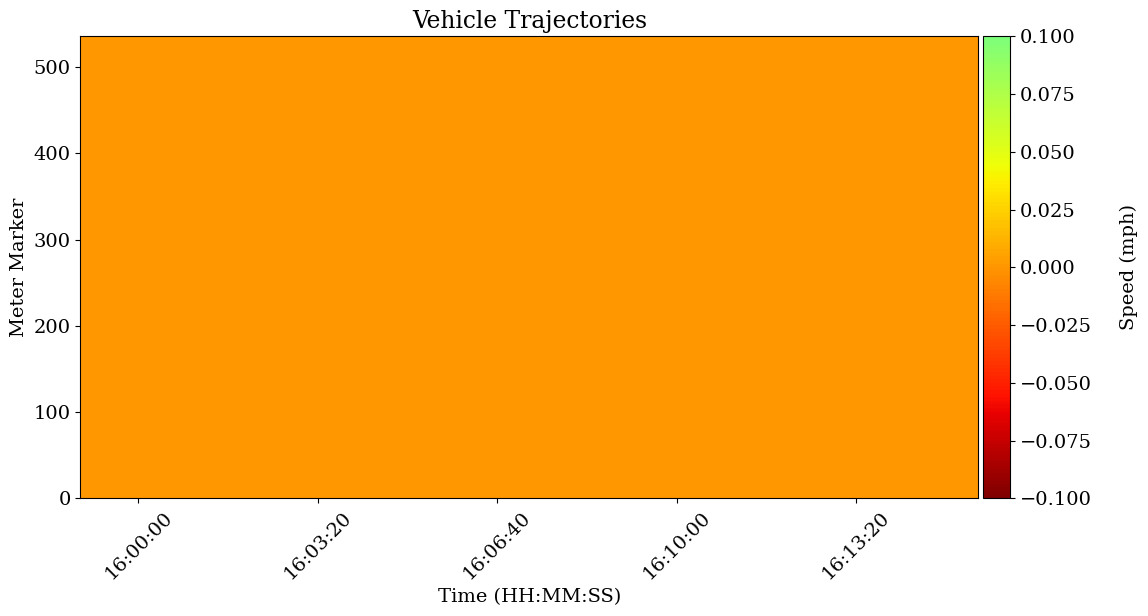

In [12]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mticker
import datetime

def plot_trajectory(title, x_res=10, t_res=2, plot_density=False):
    plt.rc('font', family='serif', size=14)
    fig, ax = plt.subplots(figsize=(12, 6))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.05)

    jet = plt.cm.jet
    colors = [jet(x) for x in np.linspace(1, 0.5, 256)]
    green_to_red = LinearSegmentedColormap.from_list('GreenToRed', colors, N=256)

    if plot_density:
        data = np.array([[global_x_t_density_dict.get((x, t), 0) for t in t_grid] for x in x_grid])
        label = 'Density'
    else:
        data = np.array([[np.mean(global_x_t_speed_dict.get((x, t), [0])) if global_x_t_speed_dict.get((x, t)) else 0 for t in t_grid] for x in x_grid])
        label = 'Speed (mph)'
        data = np.clip(data, 0, 55)  # 将速度限制在 0 到 55 mph

    # 调整时间轴和位置轴的范围
    extent = [min_timestamp + 9 * 3600, max_timestamp + 9 * 3600, min_position, max_position]
    im = ax.imshow(data, cmap=green_to_red, aspect='auto', origin='lower', extent=extent)

    plt.colorbar(im, cax=cax).set_label(label, rotation=90, labelpad=20)
    ax.set_xlabel("Time (HH:MM:SS)")
    ax.set_ylabel("Meter Marker")
    ax.set_title(title)

    # 调整x轴时间格式
    ticks_loc = ax.get_xticks().tolist()
    ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    x_datetime = [datetime.datetime.fromtimestamp(ts) for ts in ticks_loc]
    labels = [d.strftime('%H:%M:%S') for d in x_datetime]
    ax.set_xticklabels(labels, rotation=45)

    # 打印最早和最晚的时间戳
    earliest_time = datetime.datetime.fromtimestamp(min(t_grid) + 9 * 3600).strftime('%Y-%m-%d %H:%M:%S')
    latest_time = datetime.datetime.fromtimestamp(max(t_grid) + 9 * 3600).strftime('%Y-%m-%d %H:%M:%S')
    print(f"Earliest timestamp: {earliest_time}")
    print(f"Latest timestamp: {latest_time}")

    plt.show()

# 调用绘图函数
plot_trajectory('Vehicle Trajectories', x_res=10, t_res=2)
